In [ ]:
import os                       # for working with files
import numpy as np              # for numerical computationss
import pandas as pd             # for working with dataframes
import torch                    # Pytorch module
import matplotlib.pyplot as plt # for plotting informations on graph and images using tensors
import torch.nn as nn           # for creating  neural networks
from torch.utils.data import DataLoader # for dataloaders
from PIL import Image           # for checking images
import torch.nn.functional as F # for functions for calculating loss
import torchvision.transforms as transforms   # for transforming images into tensors
from torchvision.utils import make_grid       # for data checking
from torchvision.datasets import ImageFolder  # for working with classes and images
from torchsummary import summary              # for getting the summary of our models
import kagglehub
import shutil
import random
from torchvision import transforms
from tqdm.auto import tqdm
from typing import Dict, List, Tuple
import copy
from tqdm import tqdm
from typing import Dict, List, Union
from google.colab import drive
from pathlib import Path

%matplotlib inline

path = kagglehub.dataset_download("abdallahalidev/plantvillage-dataset")
print("Fichiers extraits dans :", path)
data_dir = "/root/.cache/kagglehub/datasets/abdallahalidev/plantvillage-dataset/versions/3/plantvillage dataset/color"
os.listdir(data_dir)

Fichiers extraits dans : /root/.cache/kagglehub/datasets/abdallahalidev/plantvillage-dataset/versions/3


['Corn_(maize)___Common_rust_',
 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot',
 'Raspberry___healthy',
 'Potato___Late_blight',
 'Grape___Esca_(Black_Measles)',
 'Tomato___Bacterial_spot',
 'Orange___Haunglongbing_(Citrus_greening)',
 'Grape___Black_rot',
 'Strawberry___Leaf_scorch',
 'Tomato___healthy',
 'Tomato___Late_blight',
 'Tomato___Early_blight',
 'Pepper,_bell___healthy',
 'Tomato___Septoria_leaf_spot',
 'Corn_(maize)___Northern_Leaf_Blight',
 'Tomato___Tomato_Yellow_Leaf_Curl_Virus',
 'Apple___healthy',
 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)',
 'Tomato___Leaf_Mold',
 'Peach___Bacterial_spot',
 'Cherry_(including_sour)___healthy',
 'Squash___Powdery_mildew',
 'Tomato___Tomato_mosaic_virus',
 'Potato___healthy',
 'Tomato___Spider_mites Two-spotted_spider_mite',
 'Corn_(maize)___healthy',
 'Peach___healthy',
 'Grape___healthy',
 'Apple___Black_rot',
 'Blueberry___healthy',
 'Potato___Early_blight',
 'Pepper,_bell___Bacterial_spot',
 'Soybean___healthy',
 'Strawberr

#Sans data augmentation

In [ ]:
# 1. Paramètres
seed = 42
random.seed(seed)
torch.manual_seed(seed)

batch_size = 32
pin = torch.cuda.is_available()
num_workers = os.cpu_count()

# 2. Dossier d'origine (celui contenant les 38 classes)
data_dir = data_dir
output_base_dir = "/content"
splits = ['train', 'val', 'test']
split_ratio = [0.7, 0.15, 0.15]

# 3. Répartition train / val / test
for cls in os.listdir(data_dir):
    cls_dir = os.path.join(data_dir, cls)
    if not os.path.isdir(cls_dir):
        continue

    images = [img for img in os.listdir(cls_dir)
              if img.lower().endswith(('.jpg', '.jpeg', '.png'))]
    random.shuffle(images)

    n_total = len(images)
    n_train = int(split_ratio[0] * n_total)
    n_val = int(split_ratio[1] * n_total)
    n_test = n_total - n_train - n_val

    split_counts = {'train': n_train, 'val': n_val, 'test': n_test}
    split_limits = {
        'train': range(0, n_train),
        'val': range(n_train, n_train + n_val),
        'test': range(n_train + n_val, n_total)
    }

    for split in splits:
        os.makedirs(os.path.join(output_base_dir, split, cls), exist_ok=True)

    for i, img in enumerate(images):
        for split in splits:
            if i in split_limits[split]:
                src = os.path.join(cls_dir, img)
                dst = os.path.join(output_base_dir, split, cls, img)
                shutil.copyfile(src, dst)
                break  # évite de copier plusieurs fois

# 4. Transforms
basic_transform = transforms.ToTensor() # à changer avec de la data augmentation + tard

# 5. Dossiers finaux
train_dir = os.path.join(output_base_dir, "train")
val_dir = os.path.join(output_base_dir, "val")
test_dir = os.path.join(output_base_dir, "test")

# 6. Chargement des datasets
train_dataset = ImageFolder(train_dir, transform=basic_transform)
val_dataset = ImageFolder(val_dir, transform=basic_transform)
test_dataset = ImageFolder(test_dir, transform=basic_transform)

# 7. Loaders
train_dl = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,
                      num_workers=num_workers, pin_memory=pin)
val_dl = DataLoader(val_dataset, batch_size=batch_size, shuffle=False,
                    num_workers=num_workers, pin_memory=pin)
test_dl = DataLoader(test_dataset, batch_size=batch_size, shuffle=False,
                     num_workers=num_workers, pin_memory=pin)

# 9. Vérification
print(f"Train: {len(train_dataset)} images")
print(f"Validation: {len(val_dataset)} images")
print(f"Test: {len(test_dataset)} images")


Train: 37997 images
Validation: 8129 images
Test: 8179 images


In [ ]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device) -> Tuple[float, float]:

    model.train()
    train_loss = 0.0
    correct_preds = 0
    total_samples = 0


    for X, y in dataloader:
        X, y = X.to(device), y.to(device)

        # Forward pass
        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Accuracy calculation
        y_pred_class = torch.argmax(y_pred, dim=1)
        correct_preds += (y_pred_class == y).sum().item()
        total_samples += y.size(0)


    avg_loss = train_loss / len(dataloader)
    avg_acc = correct_preds / total_samples
    return avg_loss, avg_acc


def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device: torch.device) -> Tuple[float, float]:

    model.eval()
    test_loss = 0.0
    correct_preds = 0
    total_samples = 0

    with torch.inference_mode():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)

            y_pred = model(X)
            loss = loss_fn(y_pred, y)
            test_loss += loss.item()

            y_pred_class = torch.argmax(y_pred, dim=1)
            correct_preds += (y_pred_class == y).sum().item()
            total_samples += y.size(0)


    avg_loss = test_loss / len(dataloader)
    avg_acc = correct_preds / total_samples
    return avg_loss, avg_acc




In [ ]:
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          validation_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device,
          patience: int = 10,
          track_metrics: bool = True
          ) -> Union[Dict[str, List[float]], Dict[str, float]]:
    """
    Entraîne un modèle PyTorch avec early stopping.

    Args:
        model: Le modèle à entraîner.
        train_dataloader: DataLoader pour l'entraînement.
        validation_dataloader: DataLoader pour la validation.
        optimizer: Optimiseur (ex: Adam).
        loss_fn: Fonction de perte (ex: CrossEntropyLoss).
        epochs: Nombre maximum d'époques.
        device: Appareil de calcul (ex: "cuda" ou "cpu").
        patience: Nombre d'époques sans amélioration avant arrêt.
        track_metrics: Si True, retourne les courbes complètes. Sinon, uniquement les stats finales.

    Returns:
        Dictionnaire contenant soit les courbes de loss/acc, soit juste les valeurs finales.
    """

    if track_metrics:
        results = {
            "train_loss": [],
            "train_acc": [],
            "test_loss": [],
            "test_acc": []
        }
    else:
        results = {}

    best_model_wts = copy.deepcopy(model.state_dict())
    best_val_loss = float('inf')
    best_epoch = 0
    epochs_without_improvement = 0

    for epoch in tqdm(range(epochs)):
        # ----- Phase d'entraînement -----
        train_loss, train_acc = train_step(
            model=model,
            dataloader=train_dataloader,
            loss_fn=loss_fn,
            optimizer=optimizer,
            device=device
        )

        # ----- Phase de validation -----
        val_loss, val_acc = test_step(
            model=model,
            dataloader=validation_dataloader,
            loss_fn=loss_fn,
            device=device
        )

#afficher à chaque epoch les valeurs et les ajouter aux résultats (utile pour la visualisation)
        if track_metrics:
          print(f"Epoch: {epoch+1} | "
              f"train_loss: {train_loss:.4f} | train_acc: {train_acc:.4f} | "
              f"val_loss: {val_loss:.4f} | val_acc: {val_acc:.4f}")

          results["train_loss"].append(train_loss)
          results["train_acc"].append(train_acc)
          results["test_loss"].append(val_loss)
          results["test_acc"].append(val_acc)

            # ----- Early Stopping -----
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            best_epoch = epoch
            epochs_without_improvement = 0
            print("✅ Validation loss improved — model saved.")
        else:
            epochs_without_improvement += 1
            print(f"⚠️ No improvement for {epochs_without_improvement} epoch(s).")

            if epochs_without_improvement >= patience:
                print("⏹️ Early stopping triggered.")
                break


    # Rétablir les meilleurs poids
    model.load_state_dict(best_model_wts)
    print(f"\n🏁 Best model restored from epoch {best_epoch+1} with val_loss = {best_val_loss:.4f}")
    if track_metrics:
        # Tronquer les résultats aux meilleures époques
        for key in results:
            results[key] = results[key][:best_epoch + 1]
        return results
    else:
        return {
            "final_train_loss": train_loss,
            "final_train_acc": train_acc,
            "final_val_loss": val_loss,
            "final_val_acc": val_acc,
        }

In [ ]:
num_classes = len(train_dataset.classes)

#SimpleCNN_V1

In [ ]:
class SimpleCNN_V1(nn.Module):
    def __init__(self, num_classes=num_classes):
        super().__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),  # [B, 32, 256, 256]
            nn.ReLU(),
            nn.MaxPool2d(2),                             # [B, 32, 128, 128]

            nn.Conv2d(32, 64, kernel_size=3, padding=1), # [B, 64, 128, 128]
            nn.ReLU(),
            nn.MaxPool2d(2),                             # [B, 64, 64, 64]

            nn.Conv2d(64, 128, kernel_size=3, padding=1),# [B, 128, 64, 64]
            nn.ReLU(),
            nn.MaxPool2d(2),                             # [B, 128, 32, 32]

            nn.Conv2d(128, 256, kernel_size=3, padding=1),# [B, 256, 32, 32]
            nn.ReLU(),
            nn.MaxPool2d(2),                              # [B, 256, 16, 16]

            nn.Conv2d(256, 512, kernel_size=3, padding=1),# [B, 512, 16, 16]
            nn.ReLU(),
            nn.MaxPool2d(2)                               # [B, 512, 8, 8]
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),                                # [B, 512*8*8]
            nn.Linear(512*8*8, 512), # couche cachée (pour augmenter la complexité du réseau un minimum)
            nn.ReLU(),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.classifier(x)
        return x


In [ ]:
# === Configuration ===
device = "cuda" if torch.cuda.is_available() else "cpu"
model = SimpleCNN_V1(num_classes).to(device)

LEARNING_RATE = 0.01
NUM_EPOCHS = 15


# === Perte et optimiseur ===
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

stats = train(
    model=model,
    train_dataloader=train_dl,
    validation_dataloader=val_dl,
    loss_fn=loss_fn,
    optimizer=optimizer,
    epochs=NUM_EPOCHS,
    device=device,
    patience=4,
    track_metrics=True)

  7%|▋         | 1/15 [00:26<06:07, 26.28s/it]

Epoch: 1 | train_loss: 3.5901 | train_acc: 0.3367 | val_loss: 1.5808 | val_acc: 0.5197
✅ Validation loss improved — model saved.


 13%|█▎        | 2/15 [00:50<05:28, 25.27s/it]

Epoch: 2 | train_loss: 1.2701 | train_acc: 0.6147 | val_loss: 1.1854 | val_acc: 0.6330
✅ Validation loss improved — model saved.


 20%|██        | 3/15 [01:15<04:59, 24.94s/it]

Epoch: 3 | train_loss: 1.0452 | train_acc: 0.6764 | val_loss: 1.1314 | val_acc: 0.6499
✅ Validation loss improved — model saved.


 27%|██▋       | 4/15 [01:39<04:32, 24.79s/it]

Epoch: 4 | train_loss: 0.9680 | train_acc: 0.6958 | val_loss: 1.0172 | val_acc: 0.6895
✅ Validation loss improved — model saved.


 33%|███▎      | 5/15 [02:04<04:07, 24.75s/it]

Epoch: 5 | train_loss: 0.9161 | train_acc: 0.7146 | val_loss: 0.8820 | val_acc: 0.7240
✅ Validation loss improved — model saved.


 40%|████      | 6/15 [02:29<03:42, 24.73s/it]

Epoch: 6 | train_loss: 0.8856 | train_acc: 0.7239 | val_loss: 0.9122 | val_acc: 0.7162
⚠️ No improvement for 1 epoch(s).


 47%|████▋     | 7/15 [02:53<03:17, 24.69s/it]

Epoch: 7 | train_loss: 0.8662 | train_acc: 0.7289 | val_loss: 1.3351 | val_acc: 0.6092
⚠️ No improvement for 2 epoch(s).


 53%|█████▎    | 8/15 [03:18<02:52, 24.69s/it]

Epoch: 8 | train_loss: 0.8749 | train_acc: 0.7268 | val_loss: 0.9561 | val_acc: 0.7123
⚠️ No improvement for 3 epoch(s).


 53%|█████▎    | 8/15 [03:43<03:15, 27.90s/it]

Epoch: 9 | train_loss: 0.8381 | train_acc: 0.7372 | val_loss: 0.9331 | val_acc: 0.7129
⚠️ No improvement for 4 epoch(s).
⏹️ Early stopping triggered.

🏁 Best model restored from epoch 5 with val_loss = 0.8820


In [ ]:
drive.mount('/content/drive', force_remount="True")

#on créer le répertoire
MODEL_PATH = Path("/content/drive/MyDrive/models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

#maintenant le chemin de sauvegarde
MODEL_NAME = "01_SimpleCNN_V1.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

#sauvegarder le state_dict du modèle
print(f"Saving model to : {MODEL_SAVE_PATH}")
torch.save(obj=model.state_dict(), f=MODEL_SAVE_PATH)


"""
Pour le load :

# Instantiate a fresh instance of LinearRegressionModelV2
loaded_model_1 = LinearRegressionModelV2()

# Load model state dict
loaded_model_1.load_state_dict(torch.load(MODEL_SAVE_PATH))

# Put model to target device (if your data is on GPU, model will have to be on GPU to make predictions)
loaded_model_1.to(device)

print(f"Loaded model:\n{loaded_model_1}")
print(f"Model on device:\n{next(loaded_model_1.parameters()).device}")
"""

Mounted at /content/drive
Saving model to : /content/drive/MyDrive/models/01_SimpleCNN_V1.pth


'\nPour le load :\n\n# Instantiate a fresh instance of LinearRegressionModelV2\nloaded_model_1 = LinearRegressionModelV2()\n\n# Load model state dict\nloaded_model_1.load_state_dict(torch.load(MODEL_SAVE_PATH))\n\n# Put model to target device (if your data is on GPU, model will have to be on GPU to make predictions)\nloaded_model_1.to(device)\n\nprint(f"Loaded model:\n{loaded_model_1}")\nprint(f"Model on device:\n{next(loaded_model_1.parameters()).device}")\n'

# Affichage loss / accuracy

In [ ]:
from typing import Dict, List
import matplotlib.pyplot as plt

def plot_training_curves(stats: Dict[str, List[float]]) -> None:
    """
    Affiche les courbes de loss et d'accuracy à partir des statistiques d'entraînement.

    Args:
        stats: Dictionnaire contenant les listes de 'train_loss', 'test_loss',
               'train_acc' et 'test_acc', par époque.
    """
    epochs = range(1, len(stats["train_loss"]) + 1)

    plt.figure(figsize=(12, 5))

    # --- Courbes de loss ---
    plt.subplot(1, 2, 1)
    plt.plot(epochs, stats["train_loss"], label="Train Loss")
    plt.plot(epochs, stats["test_loss"], label="Test Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss par époque")
    plt.legend()

    # --- Courbes d'accuracy ---
    plt.subplot(1, 2, 2)
    plt.plot(epochs, stats["train_acc"], label="Train Accuracy")
    plt.plot(epochs, stats["test_acc"], label="Test Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Accuracy par époque")
    plt.legend()

    plt.tight_layout()
    plt.show()


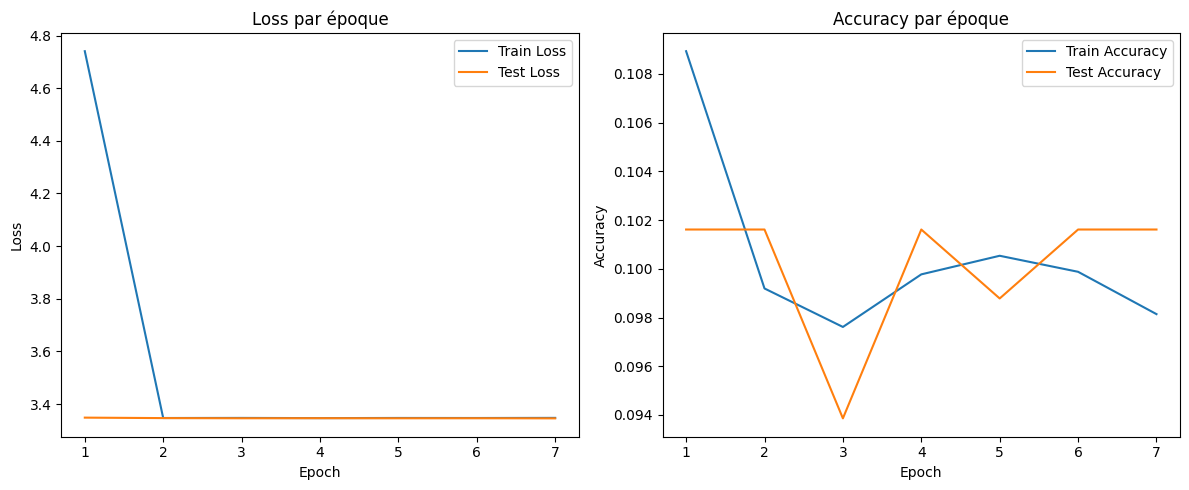

In [ ]:
plot_training_curves(stats)

#UltraDeepCNN + BN

In [ ]:
class UltraDeepCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.conv_layers = nn.Sequential(
            # Block 1 -> [B, 32, 256, 256]
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),  # -> [B, 32, 128, 128]

            # Block 2 -> [B, 64, 128, 128]
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),  # -> [B, 64, 64, 64]

            # Block 3 -> [B, 128, 64, 64]
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),  # -> [B, 128, 32, 32]

            # Block 4 -> [B, 256, 32, 32]
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),  # -> [B, 256, 16, 16]

            # Block 5 -> [B, 512, 16, 16]
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),  # -> [B, 512, 8, 8]

            # Block 6 -> [B, 512, 8, 8]
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),  # -> [B, 512, 4, 4]

            # Block 7 -> [B, 512, 4, 4]
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),  # -> [B, 512, 2, 2]

            # Block 8 -> [B, 512, 2, 2]
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)   # -> [B, 512, 1, 1]
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),                  # -> [B, 512]
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.classifier(x)
        return x


In [ ]:
# === Configuration ===
device = "cuda" if torch.cuda.is_available() else "cpu"
model = UltraDeepCNN(num_classes).to(device)

LEARNING_RATE = 0.01
NUM_EPOCHS = 15


# === Perte et optimiseur ===
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

stats = train(
    model=model,
    train_dataloader=train_dl,
    validation_dataloader=val_dl,
    loss_fn=loss_fn,
    optimizer=optimizer,
    epochs=NUM_EPOCHS,
    device=device,
    patience=4,
    track_metrics=True)

  7%|▋         | 1/15 [00:45<10:37, 45.52s/it]

Epoch: 1 | train_loss: 729.0775 | train_acc: 0.0925 | val_loss: 3.3452 | val_acc: 0.1016
✅ Validation loss improved — model saved.


 13%|█▎        | 2/15 [01:30<09:50, 45.39s/it]

Epoch: 2 | train_loss: 3.3465 | train_acc: 0.1002 | val_loss: 3.3447 | val_acc: 0.1016
✅ Validation loss improved — model saved.


 20%|██        | 3/15 [02:16<09:04, 45.37s/it]

Epoch: 3 | train_loss: 3.3465 | train_acc: 0.1009 | val_loss: 3.3453 | val_acc: 0.1016
⚠️ No improvement for 1 epoch(s).


 27%|██▋       | 4/15 [03:01<08:18, 45.33s/it]

Epoch: 4 | train_loss: 3.3470 | train_acc: 0.0998 | val_loss: 3.3458 | val_acc: 0.1016
⚠️ No improvement for 2 epoch(s).


 33%|███▎      | 5/15 [03:46<07:32, 45.30s/it]

Epoch: 5 | train_loss: 3.3472 | train_acc: 0.0998 | val_loss: 3.3450 | val_acc: 0.1016
⚠️ No improvement for 3 epoch(s).


 33%|███▎      | 5/15 [04:31<09:03, 54.36s/it]

Epoch: 6 | train_loss: 3.3470 | train_acc: 0.1009 | val_loss: 3.3450 | val_acc: 0.1016
⚠️ No improvement for 4 epoch(s).
⏹️ Early stopping triggered.

🏁 Best model restored from epoch 2 with val_loss = 3.3447


In [ ]:
drive.mount('/content/drive', force_remount="True")

#on créer le répertoire
MODEL_PATH = Path("/content/drive/MyDrive/models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

#maintenant le chemin de sauvegarde
MODEL_NAME = "01_UltraDeepCNN.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

#sauvegarder le state_dict du modèle
print(f"Saving model to : {MODEL_SAVE_PATH}")
torch.save(obj=model.state_dict(), f=MODEL_SAVE_PATH)

Mounted at /content/drive
Saving model to : /content/drive/MyDrive/models/01_UltraDeepCNN.pth


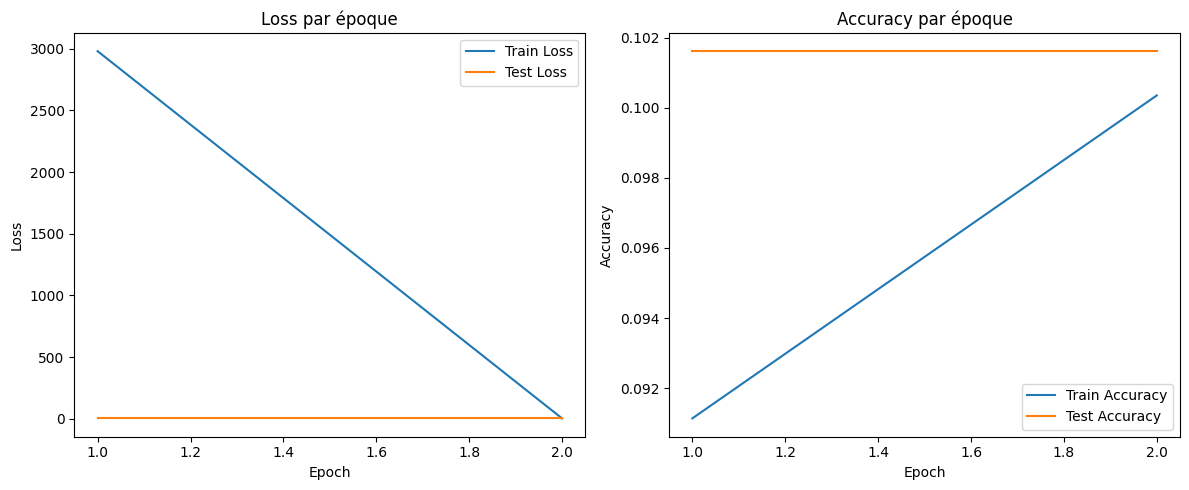

In [ ]:
plot_training_curves(stats)

In [ ]:
class UltraDeepCNN_BN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.conv_layers = nn.Sequential(
            # Block 1
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),  # [B, 32, 128, 128]

            # Block 2
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),  # [B, 64, 64, 64]

            # Block 3
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),  # [B, 128, 32, 32]

            # Block 4
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2),  # [B, 256, 16, 16]

            # Block 5
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2),  # [B, 512, 8, 8]

            # Block 6
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2),  # [B, 512, 4, 4]

            # Block 7
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2),  # [B, 512, 2, 2]

            # Block 8
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2)   # [B, 512, 1, 1]
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),                # [B, 512]
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.classifier(x)
        return x


In [ ]:
# === Configuration ===
device = "cuda" if torch.cuda.is_available() else "cpu"
model = UltraDeepCNN_BN(num_classes).to(device)

LEARNING_RATE = 0.01
NUM_EPOCHS = 20


# === Perte et optimiseur ===
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

stats = train(
    model=model,
    train_dataloader=train_dl,
    validation_dataloader=val_dl,
    loss_fn=loss_fn,
    optimizer=optimizer,
    epochs=NUM_EPOCHS,
    device=device,
    patience=10,
    track_metrics=True)

  5%|▌         | 1/20 [01:07<21:14, 67.06s/it]

Epoch: 1 | train_loss: 3.1650 | train_acc: 0.1785 | val_loss: 3.2717 | val_acc: 0.1637
✅ Validation loss improved — model saved.


 10%|█         | 2/20 [02:13<20:04, 66.93s/it]

Epoch: 2 | train_loss: 2.8932 | train_acc: 0.2270 | val_loss: 3.0390 | val_acc: 0.1917
✅ Validation loss improved — model saved.


 15%|█▌        | 3/20 [03:20<18:59, 67.01s/it]

Epoch: 3 | train_loss: 2.7695 | train_acc: 0.2405 | val_loss: 7.1587 | val_acc: 0.1372
⚠️ No improvement for 1 epoch(s).


 20%|██        | 4/20 [04:28<17:52, 67.06s/it]

Epoch: 4 | train_loss: 2.6774 | train_acc: 0.2522 | val_loss: 2.5529 | val_acc: 0.2754
✅ Validation loss improved — model saved.


 25%|██▌       | 5/20 [05:35<16:46, 67.10s/it]

Epoch: 5 | train_loss: 2.5805 | train_acc: 0.2718 | val_loss: 2.4885 | val_acc: 0.2880
✅ Validation loss improved — model saved.


 30%|███       | 6/20 [06:42<15:38, 67.06s/it]

Epoch: 6 | train_loss: 2.5472 | train_acc: 0.2835 | val_loss: 2.4236 | val_acc: 0.2796
✅ Validation loss improved — model saved.


 35%|███▌      | 7/20 [07:48<14:29, 66.91s/it]

Epoch: 7 | train_loss: 2.5093 | train_acc: 0.2939 | val_loss: 2.2560 | val_acc: 0.3656
✅ Validation loss improved — model saved.


 40%|████      | 8/20 [08:55<13:21, 66.79s/it]

Epoch: 8 | train_loss: 2.3759 | train_acc: 0.3191 | val_loss: 2.2155 | val_acc: 0.3260
✅ Validation loss improved — model saved.


 45%|████▌     | 9/20 [10:02<12:14, 66.73s/it]

Epoch: 9 | train_loss: 2.3503 | train_acc: 0.3199 | val_loss: 2.1323 | val_acc: 0.3863
✅ Validation loss improved — model saved.


 50%|█████     | 10/20 [11:08<11:06, 66.67s/it]

Epoch: 10 | train_loss: 2.2144 | train_acc: 0.3474 | val_loss: 1.9992 | val_acc: 0.3831
✅ Validation loss improved — model saved.


 55%|█████▌    | 11/20 [12:15<09:59, 66.62s/it]

Epoch: 11 | train_loss: 2.1775 | train_acc: 0.3592 | val_loss: 2.6746 | val_acc: 0.2441
⚠️ No improvement for 1 epoch(s).


 60%|██████    | 12/20 [13:21<08:52, 66.58s/it]

Epoch: 12 | train_loss: 2.1709 | train_acc: 0.3589 | val_loss: 2.0659 | val_acc: 0.3650
⚠️ No improvement for 2 epoch(s).


 65%|██████▌   | 13/20 [14:28<07:46, 66.58s/it]

Epoch: 13 | train_loss: 2.1544 | train_acc: 0.3652 | val_loss: 1.9826 | val_acc: 0.3774
✅ Validation loss improved — model saved.


 70%|███████   | 14/20 [15:34<06:39, 66.52s/it]

Epoch: 14 | train_loss: 2.2229 | train_acc: 0.3454 | val_loss: 2.0970 | val_acc: 0.3896
⚠️ No improvement for 1 epoch(s).


 75%|███████▌  | 15/20 [16:41<05:32, 66.53s/it]

Epoch: 15 | train_loss: 2.3179 | train_acc: 0.3217 | val_loss: 4.1861 | val_acc: 0.0392
⚠️ No improvement for 2 epoch(s).


 80%|████████  | 16/20 [17:47<04:25, 66.50s/it]

Epoch: 16 | train_loss: 2.2702 | train_acc: 0.3434 | val_loss: 2.0008 | val_acc: 0.3585
⚠️ No improvement for 3 epoch(s).


 85%|████████▌ | 17/20 [18:54<03:19, 66.52s/it]

Epoch: 17 | train_loss: 2.2907 | train_acc: 0.3417 | val_loss: 2.5530 | val_acc: 0.3018
⚠️ No improvement for 4 epoch(s).


 90%|█████████ | 18/20 [20:00<02:12, 66.49s/it]

Epoch: 18 | train_loss: 2.2531 | train_acc: 0.3477 | val_loss: 1.9148 | val_acc: 0.4068
✅ Validation loss improved — model saved.


 95%|█████████▌| 19/20 [21:06<01:06, 66.46s/it]

Epoch: 19 | train_loss: 2.1078 | train_acc: 0.3777 | val_loss: 1.9480 | val_acc: 0.3981
⚠️ No improvement for 1 epoch(s).


100%|██████████| 20/20 [22:13<00:00, 66.67s/it]

Epoch: 20 | train_loss: 2.0592 | train_acc: 0.3865 | val_loss: 1.8795 | val_acc: 0.4288
✅ Validation loss improved — model saved.

🏁 Best model restored from epoch 20 with val_loss = 1.8795


In [ ]:
drive.mount('/content/drive', force_remount="True")

#on créer le répertoire
MODEL_PATH = Path("/content/drive/MyDrive/models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

#maintenant le chemin de sauvegarde
MODEL_NAME = "01_UltraDeepCNN_BN.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

#sauvegarder le state_dict du modèle
print(f"Saving model to : {MODEL_SAVE_PATH}")
torch.save(obj=model.state_dict(), f=MODEL_SAVE_PATH)

Mounted at /content/drive
Saving model to : /content/drive/MyDrive/models/01_UltraDeepCNN_BN.pth


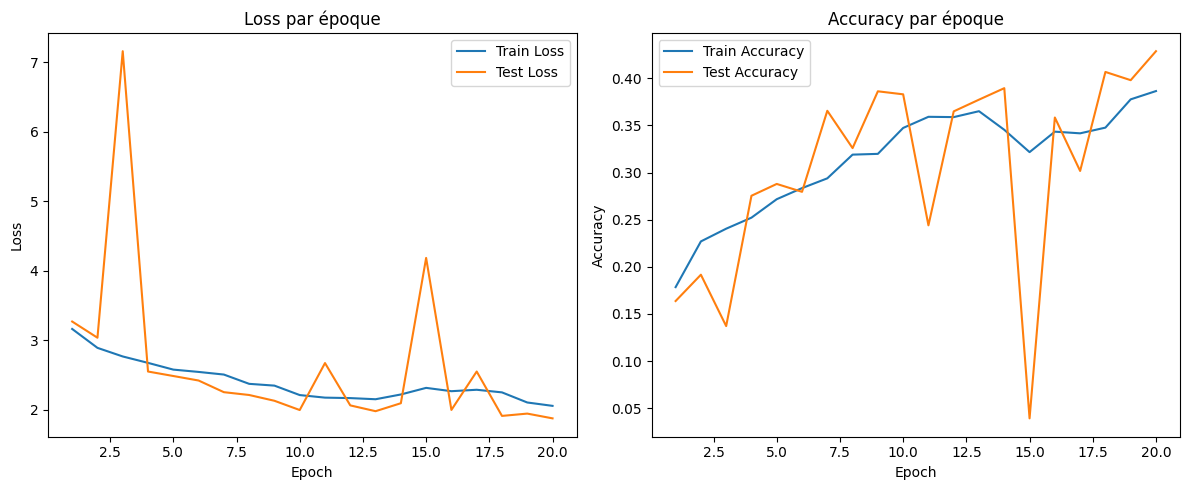

In [ ]:
plot_training_curves(stats)

#SmallCNN

In [ ]:
class SmallCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),  # [B, 32, 256, 256]
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),                             # [B, 32, 128, 128]

            nn.Conv2d(32, 64, kernel_size=3, padding=1), # [B, 64, 128, 128]
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),                             # [B, 64, 64, 64]

            nn.Conv2d(64, 128, kernel_size=3, padding=1),# [B, 128, 64, 64]
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),                             # [B, 128, 32, 32]

            nn.Conv2d(128, 256, kernel_size=3, padding=1),# [B, 256, 32, 32]
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2),                              # [B, 256, 16, 16]

            nn.Conv2d(256, 512, kernel_size=3, padding=1),# [B, 512, 16, 16]
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2)                               # [B, 512, 8, 8]
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),                                # [B, 512*8*8]
            nn.Linear(512 * 8 * 8, 512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.classifier(x)
        return x


In [ ]:
# === Configuration ===
device = "cuda" if torch.cuda.is_available() else "cpu"
model = SmallCNN(num_classes).to(device)

LEARNING_RATE = 0.01
NUM_EPOCHS = 15


# === Perte et optimiseur ===
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

stats = train(
    model=model,
    train_dataloader=train_dl,
    validation_dataloader=val_dl,
    loss_fn=loss_fn,
    optimizer=optimizer,
    epochs=NUM_EPOCHS,
    device=device,
    patience=2,
    track_metrics=True)

  7%|▋         | 1/15 [02:22<33:19, 142.81s/it]

Epoch: 1 | train_loss: 4.8076 | train_acc: 0.1012 | val_loss: 3.3457 | val_acc: 0.1016
✅ Validation loss improved — model saved.


 13%|█▎        | 2/15 [04:43<30:38, 141.46s/it]

Epoch: 2 | train_loss: 3.3468 | train_acc: 0.1012 | val_loss: 3.3454 | val_acc: 0.0988
✅ Validation loss improved — model saved.


 20%|██        | 3/15 [07:03<28:12, 141.04s/it]

Epoch: 3 | train_loss: 3.3472 | train_acc: 0.0990 | val_loss: 3.3454 | val_acc: 0.0988
✅ Validation loss improved — model saved.


In [ ]:
drive.mount('/content/drive', force_remount="True")

#on créer le répertoire
MODEL_PATH = Path("/content/drive/MyDrive/models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

#maintenant le chemin de sauvegarde
MODEL_NAME = "01_SmallCNN.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

#sauvegarder le state_dict du modèle
print(f"Saving model to : {MODEL_SAVE_PATH}")
torch.save(obj=model.state_dict(), f=MODEL_SAVE_PATH)

In [ ]:
plot_training_curves(stats)

#SmallResNet w/o data augment


In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)

        # Si les dimensions des canaux changent, on adapte le skip connection
        self.skip = nn.Identity()
        if in_channels != out_channels:
            self.skip = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        identity = self.skip(x)
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += identity
        return self.relu(out)

class SmallResNet(nn.Module):
    def __init__(self, num_classes):
        super().__init__()

        self.conv_layers = nn.Sequential(
            #un premier bloc qui sert à extraire les motifs, à réduire le coût pour les prochains residual block + avoir plus de canaux (faire le test en comparant avec que des ResidualBlock ?)
            nn.Conv2d(3, 32, kernel_size=3, padding=1),  # [B, 32, 256, 256]
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),                             # [B, 32, 128, 128]

            ResidualBlock(32, 64),
            nn.MaxPool2d(2),                             # [B, 64, 64, 64]

            ResidualBlock(64, 128),
            nn.MaxPool2d(2),                             # [B, 128, 32, 32]

            ResidualBlock(128, 256),
            nn.MaxPool2d(2),                             #  [B, 256, 16, 16]

            ResidualBlock(256, 512)                      # [B, 512, 16, 16]
        )

        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),                # [B, 512, 1, 1] permet d'avoir moins de paramètres + pas besoin de connaître la taille en entrée
            nn.Flatten(),                                # [B, 512]
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.classifier(x)
        return x


In [ ]:
# === Configuration ===
device = "cuda" if torch.cuda.is_available() else "cpu"
model = SmallResNet(num_classes).to(device)

LEARNING_RATE = 0.01
NUM_EPOCHS = 20


# === Perte et optimiseur ===
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

stats = train(
    model=model,
    train_dataloader=train_dl,
    validation_dataloader=val_dl,
    loss_fn=loss_fn,
    optimizer=optimizer,
    epochs=NUM_EPOCHS,
    device=device,
    patience=10,
    track_metrics=True)


  5%|▌         | 1/20 [00:52<16:37, 52.51s/it]

Epoch: 1 | train_loss: 1.9119 | train_acc: 0.4570 | val_loss: 1.4884 | val_acc: 0.5820
✅ Validation loss improved — model saved.


 10%|█         | 2/20 [01:45<15:46, 52.56s/it]

Epoch: 2 | train_loss: 0.9496 | train_acc: 0.7072 | val_loss: 0.6104 | val_acc: 0.7992
✅ Validation loss improved — model saved.


 15%|█▌        | 3/20 [02:37<14:51, 52.43s/it]

Epoch: 3 | train_loss: 0.6310 | train_acc: 0.8001 | val_loss: 0.6499 | val_acc: 0.7995
⚠️ No improvement for 1 epoch(s).


 20%|██        | 4/20 [03:29<13:59, 52.47s/it]

Epoch: 4 | train_loss: 0.4876 | train_acc: 0.8453 | val_loss: 0.3469 | val_acc: 0.8901
✅ Validation loss improved — model saved.


 25%|██▌       | 5/20 [04:22<13:08, 52.56s/it]

Epoch: 5 | train_loss: 0.3836 | train_acc: 0.8786 | val_loss: 1.0783 | val_acc: 0.7666
⚠️ No improvement for 1 epoch(s).


 30%|███       | 6/20 [05:15<12:18, 52.75s/it]

Epoch: 6 | train_loss: 0.3036 | train_acc: 0.9030 | val_loss: 0.2960 | val_acc: 0.9123
✅ Validation loss improved — model saved.


 35%|███▌      | 7/20 [06:08<11:25, 52.75s/it]

Epoch: 7 | train_loss: 0.2639 | train_acc: 0.9161 | val_loss: 0.3068 | val_acc: 0.9258
⚠️ No improvement for 1 epoch(s).


 40%|████      | 8/20 [07:01<10:32, 52.68s/it]

Epoch: 8 | train_loss: 0.2237 | train_acc: 0.9279 | val_loss: 0.3040 | val_acc: 0.9145
⚠️ No improvement for 2 epoch(s).


 45%|████▌     | 9/20 [07:53<09:38, 52.57s/it]

Epoch: 9 | train_loss: 0.2077 | train_acc: 0.9345 | val_loss: 0.1461 | val_acc: 0.9582
✅ Validation loss improved — model saved.


 50%|█████     | 10/20 [08:45<08:45, 52.51s/it]

Epoch: 10 | train_loss: 0.1846 | train_acc: 0.9425 | val_loss: 0.1488 | val_acc: 0.9571
⚠️ No improvement for 1 epoch(s).


 55%|█████▌    | 11/20 [09:38<07:52, 52.44s/it]

Epoch: 11 | train_loss: 0.1595 | train_acc: 0.9494 | val_loss: 0.0970 | val_acc: 0.9701
✅ Validation loss improved — model saved.


 60%|██████    | 12/20 [10:30<06:59, 52.41s/it]

Epoch: 12 | train_loss: 0.1524 | train_acc: 0.9515 | val_loss: 0.1547 | val_acc: 0.9523
⚠️ No improvement for 1 epoch(s).


 65%|██████▌   | 13/20 [11:22<06:07, 52.44s/it]

Epoch: 13 | train_loss: 0.1390 | train_acc: 0.9574 | val_loss: 0.1175 | val_acc: 0.9638
⚠️ No improvement for 2 epoch(s).


 70%|███████   | 14/20 [12:15<05:14, 52.45s/it]

Epoch: 14 | train_loss: 0.1298 | train_acc: 0.9601 | val_loss: 0.7557 | val_acc: 0.8545
⚠️ No improvement for 3 epoch(s).


 75%|███████▌  | 15/20 [13:07<04:22, 52.45s/it]

Epoch: 15 | train_loss: 0.1197 | train_acc: 0.9631 | val_loss: 0.2800 | val_acc: 0.9366
⚠️ No improvement for 4 epoch(s).


 80%|████████  | 16/20 [14:00<03:29, 52.41s/it]

Epoch: 16 | train_loss: 0.1040 | train_acc: 0.9671 | val_loss: 0.1040 | val_acc: 0.9722
⚠️ No improvement for 5 epoch(s).


 85%|████████▌ | 17/20 [14:52<02:37, 52.37s/it]

Epoch: 17 | train_loss: 0.1023 | train_acc: 0.9681 | val_loss: 0.2010 | val_acc: 0.9483
⚠️ No improvement for 6 epoch(s).


 90%|█████████ | 18/20 [15:44<01:44, 52.37s/it]

Epoch: 18 | train_loss: 0.0929 | train_acc: 0.9718 | val_loss: 0.1060 | val_acc: 0.9726
⚠️ No improvement for 7 epoch(s).


 95%|█████████▌| 19/20 [16:37<00:52, 52.45s/it]

Epoch: 19 | train_loss: 0.0906 | train_acc: 0.9722 | val_loss: 0.0619 | val_acc: 0.9820
✅ Validation loss improved — model saved.


100%|██████████| 20/20 [17:29<00:00, 52.49s/it]

Epoch: 20 | train_loss: 0.0968 | train_acc: 0.9715 | val_loss: 0.0849 | val_acc: 0.9750
⚠️ No improvement for 1 epoch(s).

🏁 Best model restored from epoch 19 with val_loss = 0.0619


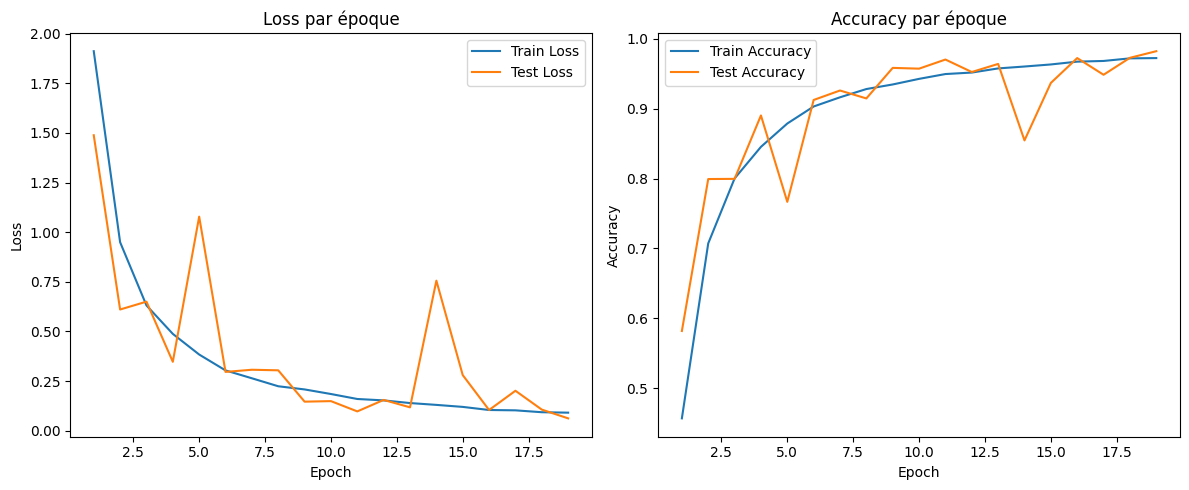

In [ ]:
plot_training_curves(stats)

#ResidualCNN w/o Data Augment

In [ ]:
import torch.nn as nn

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, stride=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, stride=1)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.need_skip_conv = in_channels != out_channels
        if self.need_skip_conv:
            self.skip = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1),
                nn.BatchNorm2d(out_channels)
            )
        else:
            self.skip = nn.Identity()

    def forward(self, x):
        identity = self.skip(x)
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        return self.relu(out + identity)

class ResidualCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.initial = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU()
        )

        self.layer1 = nn.Sequential(
            ResidualBlock(32, 64),
            nn.MaxPool2d(2)  # [B, 64, H/2, W/2]
        )
        self.layer2 = nn.Sequential(
            ResidualBlock(64, 128),
            nn.MaxPool2d(2)  # [B, 128, H/4, W/4]
        )
        self.layer3 = nn.Sequential(
            ResidualBlock(128, 256),
            nn.MaxPool2d(2)  # [B, 256, H/8, W/8]
        )
        self.layer4 = nn.Sequential(
            ResidualBlock(256, 512),
            nn.MaxPool2d(2)  # [B, 512, H/16, W/16]
        )
        self.pool = nn.AdaptiveAvgPool2d((1, 1))      # [B, 512, 1, 1]

        self.classifier = nn.Sequential(
            nn.Flatten(),                             # [B, 512]
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.initial(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.pool(x)
        x = self.classifier(x)
        return x


In [ ]:
# === Configuration ===
device = "cuda" if torch.cuda.is_available() else "cpu"
model = ResidualCNN(num_classes).to(device)

LEARNING_RATE = 0.01
NUM_EPOCHS = 20


# === Perte et optimiseur ===
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

stats = train(
    model=model,
    train_dataloader=train_dl,
    validation_dataloader=val_dl,
    loss_fn=loss_fn,
    optimizer=optimizer,
    epochs=NUM_EPOCHS,
    device=device,
    patience=10,
    track_metrics=True)


  5%|▌         | 1/20 [02:23<45:24, 143.40s/it]

Epoch: 1 | train_loss: 1.7653 | train_acc: 0.4842 | val_loss: 0.9617 | val_acc: 0.7080
✅ Validation loss improved — model saved.


 10%|█         | 2/20 [04:46<43:02, 143.48s/it]

Epoch: 2 | train_loss: 0.8638 | train_acc: 0.7298 | val_loss: 0.6095 | val_acc: 0.8040
✅ Validation loss improved — model saved.


 15%|█▌        | 3/20 [07:10<40:38, 143.42s/it]

Epoch: 3 | train_loss: 0.5887 | train_acc: 0.8136 | val_loss: 0.4260 | val_acc: 0.8627
✅ Validation loss improved — model saved.


 20%|██        | 4/20 [09:33<38:14, 143.41s/it]

Epoch: 4 | train_loss: 0.4489 | train_acc: 0.8576 | val_loss: 0.5055 | val_acc: 0.8606
⚠️ No improvement for 1 epoch(s).


 25%|██▌       | 5/20 [11:57<35:52, 143.48s/it]

Epoch: 5 | train_loss: 0.3499 | train_acc: 0.8886 | val_loss: 0.2356 | val_acc: 0.9247
✅ Validation loss improved — model saved.


 30%|███       | 6/20 [14:20<33:28, 143.50s/it]

Epoch: 6 | train_loss: 0.2892 | train_acc: 0.9088 | val_loss: 0.1667 | val_acc: 0.9432
✅ Validation loss improved — model saved.


 35%|███▌      | 7/20 [16:44<31:05, 143.48s/it]

Epoch: 7 | train_loss: 0.2568 | train_acc: 0.9202 | val_loss: 0.1624 | val_acc: 0.9499
✅ Validation loss improved — model saved.


 40%|████      | 8/20 [19:07<28:41, 143.50s/it]

Epoch: 8 | train_loss: 0.2221 | train_acc: 0.9287 | val_loss: 0.1010 | val_acc: 0.9662
✅ Validation loss improved — model saved.


 45%|████▌     | 9/20 [21:31<26:18, 143.50s/it]

Epoch: 9 | train_loss: 0.2029 | train_acc: 0.9369 | val_loss: 1.5534 | val_acc: 0.7147
⚠️ No improvement for 1 epoch(s).


 50%|█████     | 10/20 [23:54<23:55, 143.52s/it]

Epoch: 10 | train_loss: 0.1743 | train_acc: 0.9457 | val_loss: 0.0965 | val_acc: 0.9737
✅ Validation loss improved — model saved.


 55%|█████▌    | 11/20 [26:18<21:32, 143.56s/it]

Epoch: 11 | train_loss: 0.1672 | train_acc: 0.9478 | val_loss: 0.0948 | val_acc: 0.9713
✅ Validation loss improved — model saved.


 60%|██████    | 12/20 [28:41<19:08, 143.51s/it]

Epoch: 12 | train_loss: 0.1429 | train_acc: 0.9562 | val_loss: 0.0877 | val_acc: 0.9739
✅ Validation loss improved — model saved.


 65%|██████▌   | 13/20 [31:05<16:44, 143.47s/it]

Epoch: 13 | train_loss: 0.1387 | train_acc: 0.9566 | val_loss: 0.1357 | val_acc: 0.9616
⚠️ No improvement for 1 epoch(s).


 70%|███████   | 14/20 [33:28<14:20, 143.42s/it]

Epoch: 14 | train_loss: 0.1258 | train_acc: 0.9611 | val_loss: 0.2051 | val_acc: 0.9406
⚠️ No improvement for 2 epoch(s).


 75%|███████▌  | 15/20 [35:51<11:56, 143.35s/it]

Epoch: 15 | train_loss: 0.1130 | train_acc: 0.9654 | val_loss: 0.0846 | val_acc: 0.9772
✅ Validation loss improved — model saved.


 80%|████████  | 16/20 [38:14<09:33, 143.28s/it]

Epoch: 16 | train_loss: 0.1108 | train_acc: 0.9650 | val_loss: 0.0600 | val_acc: 0.9835
✅ Validation loss improved — model saved.


 85%|████████▌ | 17/20 [40:38<07:09, 143.23s/it]

Epoch: 17 | train_loss: 0.1137 | train_acc: 0.9663 | val_loss: 0.0908 | val_acc: 0.9760
⚠️ No improvement for 1 epoch(s).


 90%|█████████ | 18/20 [43:01<04:46, 143.17s/it]

Epoch: 18 | train_loss: 0.1001 | train_acc: 0.9690 | val_loss: 0.0831 | val_acc: 0.9799
⚠️ No improvement for 2 epoch(s).


 95%|█████████▌| 19/20 [45:24<02:23, 143.15s/it]

Epoch: 19 | train_loss: 0.0973 | train_acc: 0.9704 | val_loss: 0.0604 | val_acc: 0.9819
⚠️ No improvement for 3 epoch(s).


100%|██████████| 20/20 [47:47<00:00, 143.36s/it]

Epoch: 20 | train_loss: 0.0939 | train_acc: 0.9714 | val_loss: 0.0977 | val_acc: 0.9723
⚠️ No improvement for 4 epoch(s).

🏁 Best model restored from epoch 16 with val_loss = 0.0600


#Data Augmentation

In [ ]:
import shutil
import random
from torchvision import transforms

# 1. Paramètres
seed = 42
random.seed(seed)
torch.manual_seed(seed)

batch_size = 32
pin = torch.cuda.is_available()
num_workers = os.cpu_count()

# 2. Dossier d'origine (celui contenant les 38 classes)
data_dir = data_dir
output_base_dir = "/content"
splits = ['train', 'val', 'test']
split_ratio = [0.7, 0.15, 0.15]


# 3. Répartition train / val / test
for cls in os.listdir(data_dir):
    cls_dir = os.path.join(data_dir, cls)
    if not os.path.isdir(cls_dir):
        continue

    images = [img for img in os.listdir(cls_dir)
              if img.lower().endswith(('.jpg', '.jpeg', '.png'))]
    random.shuffle(images)

    n_total = len(images)
    n_train = int(split_ratio[0] * n_total)
    n_val = int(split_ratio[1] * n_total)
    n_test = n_total - n_train - n_val

    split_counts = {'train': n_train, 'val': n_val, 'test': n_test}
    split_limits = {
        'train': range(0, n_train),
        'val': range(n_train, n_train + n_val),
        'test': range(n_train + n_val, n_total)
    }

    for split in splits:
        os.makedirs(os.path.join(output_base_dir, split, cls), exist_ok=True)

    for i, img in enumerate(images):
        for split in splits:
            if i in split_limits[split]:
                src = os.path.join(cls_dir, img)
                dst = os.path.join(output_base_dir, split, cls, img)
                shutil.copyfile(src, dst)
                break  # évite de copier plusieurs fois

# 4. Transforms
# Valeurs standard pour images RGB dans [0,1]
# Si tu préfères ImageNet : change mean/std
mean = [0.5, 0.5, 0.5]
std = [0.5, 0.5, 0.5]

# Transformations pour l'entraînement (avec data augmentation)
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

# Transformations pour la validation/test (sans augmentation)
test_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])


# 5. Dossiers finaux
train_dir = os.path.join(output_base_dir, "train")
val_dir = os.path.join(output_base_dir, "val")
test_dir = os.path.join(output_base_dir, "test")

# 6. Chargement des datasets
train_dataset = ImageFolder(train_dir, transform=train_transform)
val_dataset = ImageFolder(val_dir, transform=test_transform)
test_dataset = ImageFolder(test_dir, transform=test_transform)


# 7. Loaders
train_dl = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,
                      num_workers=num_workers, pin_memory=pin)
val_dl = DataLoader(val_dataset, batch_size=batch_size, shuffle=False,
                    num_workers=num_workers, pin_memory=pin)
test_dl = DataLoader(test_dataset, batch_size=batch_size, shuffle=False,
                     num_workers=num_workers, pin_memory=pin)

# 9. Vérification
print(f"Train: {len(train_dataset)} images")
print(f"Validation: {len(val_dataset)} images")
print(f"Test: {len(test_dataset)} images")

num_classes = len(train_dataset.classes)

Train: 37997 images
Validation: 8129 images
Test: 8179 images


In [ ]:
# === Configuration ===
device = "cuda" if torch.cuda.is_available() else "cpu"
model = SmallCNN(num_classes).to(device)

LEARNING_RATE = 0.01
NUM_EPOCHS = 15


# === Perte et optimiseur ===
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

stats = train(
    model=model,
    train_dataloader=train_dl,
    validation_dataloader=val_dl,
    loss_fn=loss_fn,
    optimizer=optimizer,
    epochs=NUM_EPOCHS,
    device=device,
    patience=2,
    track_metrics=True)

  7%|▋         | 1/15 [02:29<34:47, 149.12s/it]

Epoch: 1 | train_loss: 5.1473 | train_acc: 0.0996 | val_loss: 3.3479 | val_acc: 0.1016
✅ Validation loss improved — model saved.


 13%|█▎        | 2/15 [04:57<32:11, 148.60s/it]

Epoch: 2 | train_loss: 3.3469 | train_acc: 0.0994 | val_loss: 3.3465 | val_acc: 0.1016
✅ Validation loss improved — model saved.


 20%|██        | 3/15 [07:26<29:43, 148.64s/it]

Epoch: 3 | train_loss: 3.3472 | train_acc: 0.0976 | val_loss: 3.3459 | val_acc: 0.0939
✅ Validation loss improved — model saved.


 27%|██▋       | 4/15 [09:57<27:27, 149.74s/it]

Epoch: 4 | train_loss: 3.3465 | train_acc: 0.0999 | val_loss: 3.3462 | val_acc: 0.1016
⚠️ No improvement for 1 epoch(s).


 33%|███▎      | 5/15 [12:25<24:50, 149.05s/it]

Epoch: 5 | train_loss: 3.3471 | train_acc: 0.1006 | val_loss: 3.3459 | val_acc: 0.0988
✅ Validation loss improved — model saved.


 40%|████      | 6/15 [14:53<22:19, 148.86s/it]

Epoch: 6 | train_loss: 3.3469 | train_acc: 0.0999 | val_loss: 3.3460 | val_acc: 0.1016
⚠️ No improvement for 1 epoch(s).


 47%|████▋     | 7/15 [17:22<19:51, 148.96s/it]

Epoch: 7 | train_loss: 3.3474 | train_acc: 0.0981 | val_loss: 3.3456 | val_acc: 0.1016
✅ Validation loss improved — model saved.


 53%|█████▎    | 8/15 [19:51<17:21, 148.73s/it]

Epoch: 8 | train_loss: 3.3469 | train_acc: 0.1009 | val_loss: 3.3464 | val_acc: 0.1016
⚠️ No improvement for 1 epoch(s).


 53%|█████▎    | 8/15 [22:20<19:32, 167.50s/it]

Epoch: 9 | train_loss: 3.3721 | train_acc: 0.0987 | val_loss: 3.3456 | val_acc: 0.0939
⚠️ No improvement for 2 epoch(s).
⏹️ Early stopping triggered.

🏁 Best model restored from epoch 7 with val_loss = 3.3456


In [ ]:
drive.mount('/content/drive', force_remount="True")

#on créer le répertoire
MODEL_PATH = Path("/content/drive/MyDrive/models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

#maintenant le chemin de sauvegarde
MODEL_NAME = "02_SmallCNN_wDataAugmentation.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

#sauvegarder le state_dict du modèle
print(f"Saving model to : {MODEL_SAVE_PATH}")
torch.save(obj=model.state_dict(), f=MODEL_SAVE_PATH)

Mounted at /content/drive
Saving model to : /content/drive/MyDrive/models/02_SmallCNN_wDataAugmentation.pth


# Residual Networks

## Small ResNet w/ data augment

In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)

        # Si les dimensions des canaux changent, on adapte le skip connection
        self.skip = nn.Identity()
        if in_channels != out_channels:
            self.skip = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        identity = self.skip(x)
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += identity
        return self.relu(out)

class SmallResNet(nn.Module):
    def __init__(self, num_classes):
        super().__init__()

        self.conv_layers = nn.Sequential(
            #un premier bloc qui sert à extraire les motifs, à réduire le coût pour les prochains residual block + avoir plus de canaux (faire le test en comparant avec que des ResidualBlock ?)
            nn.Conv2d(3, 32, kernel_size=3, padding=1),  # [B, 32, 256, 256]
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),                             # [B, 32, 128, 128]

            ResidualBlock(32, 64),
            nn.MaxPool2d(2),                             # [B, 64, 64, 64]

            ResidualBlock(64, 128),
            nn.MaxPool2d(2),                             # [B, 128, 32, 32]

            ResidualBlock(128, 256),
            nn.MaxPool2d(2),                             #  [B, 256, 16, 16]

            ResidualBlock(256, 512)                      # [B, 512, 16, 16]
        )

        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),                # [B, 512, 1, 1] permet d'avoir moins de paramètres + pas besoin de connaître la taille en entrée
            nn.Flatten(),                                # [B, 512]
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.classifier(x)
        return x


In [ ]:
# === Configuration ===
device = "cuda" if torch.cuda.is_available() else "cpu"
model = SmallResNet(num_classes).to(device)

LEARNING_RATE = 0.01
NUM_EPOCHS = 20


# === Perte et optimiseur ===
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

stats = train(
    model=model,
    train_dataloader=train_dl,
    validation_dataloader=val_dl,
    loss_fn=loss_fn,
    optimizer=optimizer,
    epochs=NUM_EPOCHS,
    device=device,
    patience=10,
    track_metrics=True)


  5%|▌         | 1/20 [00:55<17:25, 55.02s/it]

Epoch: 1 | train_loss: 2.0039 | train_acc: 0.4240 | val_loss: 1.0296 | val_acc: 0.6891
✅ Validation loss improved — model saved.


 10%|█         | 2/20 [01:48<16:09, 53.83s/it]

Epoch: 2 | train_loss: 1.0548 | train_acc: 0.6758 | val_loss: 0.9750 | val_acc: 0.6760
✅ Validation loss improved — model saved.


 15%|█▌        | 3/20 [02:40<15:08, 53.44s/it]

Epoch: 3 | train_loss: 0.7188 | train_acc: 0.7728 | val_loss: 0.3866 | val_acc: 0.8737
✅ Validation loss improved — model saved.


 20%|██        | 4/20 [03:33<14:11, 53.23s/it]

Epoch: 4 | train_loss: 0.5297 | train_acc: 0.8306 | val_loss: 0.2780 | val_acc: 0.9095
✅ Validation loss improved — model saved.


 25%|██▌       | 5/20 [04:26<13:17, 53.14s/it]

Epoch: 5 | train_loss: 0.4229 | train_acc: 0.8630 | val_loss: 0.3212 | val_acc: 0.8975
⚠️ No improvement for 1 epoch(s).


 30%|███       | 6/20 [05:19<12:23, 53.10s/it]

Epoch: 6 | train_loss: 0.3366 | train_acc: 0.8905 | val_loss: 0.2104 | val_acc: 0.9349
✅ Validation loss improved — model saved.


 35%|███▌      | 7/20 [06:12<11:29, 53.04s/it]

Epoch: 7 | train_loss: 0.2935 | train_acc: 0.9079 | val_loss: 0.1131 | val_acc: 0.9638
✅ Validation loss improved — model saved.


 40%|████      | 8/20 [07:05<10:35, 52.97s/it]

Epoch: 8 | train_loss: 0.2459 | train_acc: 0.9206 | val_loss: 0.1391 | val_acc: 0.9569
⚠️ No improvement for 1 epoch(s).


 45%|████▌     | 9/20 [07:58<09:42, 52.99s/it]

Epoch: 9 | train_loss: 0.2251 | train_acc: 0.9282 | val_loss: 0.1348 | val_acc: 0.9557
⚠️ No improvement for 2 epoch(s).


 50%|█████     | 10/20 [08:51<08:49, 53.00s/it]

Epoch: 10 | train_loss: 0.1989 | train_acc: 0.9374 | val_loss: 0.1258 | val_acc: 0.9628
⚠️ No improvement for 3 epoch(s).


 55%|█████▌    | 11/20 [09:44<07:57, 53.02s/it]

Epoch: 11 | train_loss: 0.1772 | train_acc: 0.9448 | val_loss: 0.0818 | val_acc: 0.9742
✅ Validation loss improved — model saved.


 60%|██████    | 12/20 [10:37<07:04, 53.02s/it]

Epoch: 12 | train_loss: 0.1618 | train_acc: 0.9492 | val_loss: 0.3120 | val_acc: 0.9208
⚠️ No improvement for 1 epoch(s).


 65%|██████▌   | 13/20 [11:30<06:11, 53.05s/it]

Epoch: 13 | train_loss: 0.1607 | train_acc: 0.9508 | val_loss: 0.1388 | val_acc: 0.9625
⚠️ No improvement for 2 epoch(s).


 70%|███████   | 14/20 [12:23<05:17, 52.98s/it]

Epoch: 14 | train_loss: 0.1447 | train_acc: 0.9549 | val_loss: 0.1068 | val_acc: 0.9685
⚠️ No improvement for 3 epoch(s).


 75%|███████▌  | 15/20 [13:16<04:24, 52.99s/it]

Epoch: 15 | train_loss: 0.1287 | train_acc: 0.9604 | val_loss: 0.0931 | val_acc: 0.9715
⚠️ No improvement for 4 epoch(s).


 80%|████████  | 16/20 [14:09<03:32, 53.02s/it]

Epoch: 16 | train_loss: 0.1266 | train_acc: 0.9608 | val_loss: 0.0721 | val_acc: 0.9799
✅ Validation loss improved — model saved.


 85%|████████▌ | 17/20 [15:02<02:39, 53.02s/it]

Epoch: 17 | train_loss: 0.1111 | train_acc: 0.9649 | val_loss: 0.0568 | val_acc: 0.9846
✅ Validation loss improved — model saved.


 90%|█████████ | 18/20 [15:55<01:45, 52.99s/it]

Epoch: 18 | train_loss: 0.1129 | train_acc: 0.9662 | val_loss: 0.0693 | val_acc: 0.9793
⚠️ No improvement for 1 epoch(s).


 95%|█████████▌| 19/20 [16:48<00:53, 53.00s/it]

Epoch: 19 | train_loss: 0.1048 | train_acc: 0.9672 | val_loss: 0.0680 | val_acc: 0.9809
⚠️ No improvement for 2 epoch(s).


100%|██████████| 20/20 [17:41<00:00, 53.09s/it]

Epoch: 20 | train_loss: 0.1037 | train_acc: 0.9689 | val_loss: 0.1044 | val_acc: 0.9702
⚠️ No improvement for 3 epoch(s).

🏁 Best model restored from epoch 17 with val_loss = 0.0568


In [ ]:
drive.mount('/content/drive', force_remount="True")

#on créer le répertoire
MODEL_PATH = Path("/content/drive/MyDrive/models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

#maintenant le chemin de sauvegarde
MODEL_NAME = "01_SmallResNet.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

#sauvegarder le state_dict du modèle
print(f"Saving model to : {MODEL_SAVE_PATH}")
torch.save(obj=model.state_dict(), f=MODEL_SAVE_PATH)

Mounted at /content/drive
Saving model to : /content/drive/MyDrive/models/01_SmallResNet.pth


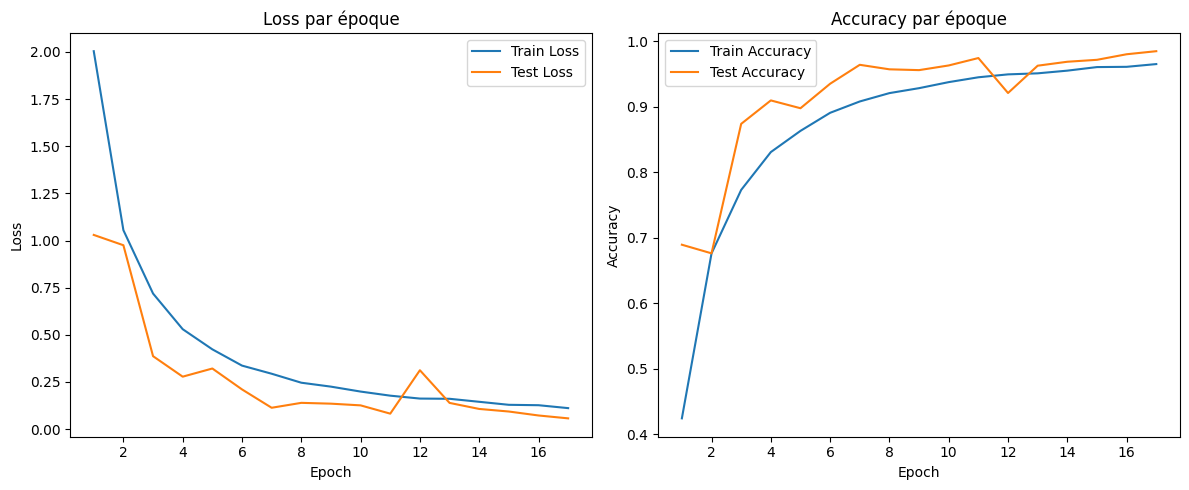

In [ ]:
plot_training_curves(stats)

# ResNet (MaxPool, stride 1)

In [ ]:
import torch.nn as nn

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, stride=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, stride=1)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.need_skip_conv = in_channels != out_channels
        if self.need_skip_conv:
            self.skip = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1),
                nn.BatchNorm2d(out_channels)
            )
        else:
            self.skip = nn.Identity()

    def forward(self, x):
        identity = self.skip(x)
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        return self.relu(out + identity)

class ResidualCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.initial = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU()
        )

        self.layer1 = nn.Sequential(
            ResidualBlock(32, 64),
            nn.MaxPool2d(2)  # [B, 64, H/2, W/2]
        )
        self.layer2 = nn.Sequential(
            ResidualBlock(64, 128),
            nn.MaxPool2d(2)  # [B, 128, H/4, W/4]
        )
        self.layer3 = nn.Sequential(
            ResidualBlock(128, 256),
            nn.MaxPool2d(2)  # [B, 256, H/8, W/8]
        )
        self.layer4 = nn.Sequential(
            ResidualBlock(256, 512),
            nn.MaxPool2d(2)  # [B, 512, H/16, W/16]
        )
        self.pool = nn.AdaptiveAvgPool2d((1, 1))      # [B, 512, 1, 1]

        self.classifier = nn.Sequential(
            nn.Flatten(),                             # [B, 512]
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.initial(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.pool(x)
        x = self.classifier(x)
        return x


In [ ]:
# === Configuration ===
device = "cuda" if torch.cuda.is_available() else "cpu"
model = ResidualCNN(num_classes).to(device)

LEARNING_RATE = 0.01
NUM_EPOCHS = 20


# === Perte et optimiseur ===
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

stats = train(
    model=model,
    train_dataloader=train_dl,
    validation_dataloader=val_dl,
    loss_fn=loss_fn,
    optimizer=optimizer,
    epochs=NUM_EPOCHS,
    device=device,
    patience=10,
    track_metrics=True)


  5%|▌         | 1/20 [02:23<45:21, 143.24s/it]

Epoch: 1 | train_loss: 1.9560 | train_acc: 0.4488 | val_loss: 1.2453 | val_acc: 0.6241
✅ Validation loss improved — model saved.


 10%|█         | 2/20 [04:46<42:57, 143.18s/it]

Epoch: 2 | train_loss: 0.9463 | train_acc: 0.7081 | val_loss: 0.5691 | val_acc: 0.8184
✅ Validation loss improved — model saved.


 15%|█▌        | 3/20 [07:09<40:33, 143.15s/it]

Epoch: 3 | train_loss: 0.6556 | train_acc: 0.7939 | val_loss: 0.4140 | val_acc: 0.8631
✅ Validation loss improved — model saved.


 20%|██        | 4/20 [09:32<38:09, 143.11s/it]

Epoch: 4 | train_loss: 0.5226 | train_acc: 0.8360 | val_loss: 0.2504 | val_acc: 0.9181
✅ Validation loss improved — model saved.


 25%|██▌       | 5/20 [11:55<35:47, 143.14s/it]

Epoch: 5 | train_loss: 0.4315 | train_acc: 0.8635 | val_loss: 0.2397 | val_acc: 0.9173
✅ Validation loss improved — model saved.


 30%|███       | 6/20 [14:19<33:24, 143.18s/it]

Epoch: 6 | train_loss: 0.3815 | train_acc: 0.8792 | val_loss: 0.2039 | val_acc: 0.9327
✅ Validation loss improved — model saved.


 35%|███▌      | 7/20 [16:42<31:00, 143.15s/it]

Epoch: 7 | train_loss: 0.3331 | train_acc: 0.8968 | val_loss: 0.1828 | val_acc: 0.9440
✅ Validation loss improved — model saved.


 40%|████      | 8/20 [19:05<28:38, 143.21s/it]

Epoch: 8 | train_loss: 0.2903 | train_acc: 0.9092 | val_loss: 0.1987 | val_acc: 0.9406
⚠️ No improvement for 1 epoch(s).


 45%|████▌     | 9/20 [21:28<26:14, 143.13s/it]

Epoch: 9 | train_loss: 0.2650 | train_acc: 0.9174 | val_loss: 0.1552 | val_acc: 0.9546
✅ Validation loss improved — model saved.


 50%|█████     | 10/20 [23:51<23:51, 143.19s/it]

Epoch: 10 | train_loss: 0.2408 | train_acc: 0.9253 | val_loss: 0.1582 | val_acc: 0.9485
⚠️ No improvement for 1 epoch(s).


 55%|█████▌    | 11/20 [26:14<21:28, 143.21s/it]

Epoch: 11 | train_loss: 0.2147 | train_acc: 0.9327 | val_loss: 0.1933 | val_acc: 0.9454
⚠️ No improvement for 2 epoch(s).


 60%|██████    | 12/20 [28:38<19:05, 143.24s/it]

Epoch: 12 | train_loss: 0.1926 | train_acc: 0.9408 | val_loss: 0.0865 | val_acc: 0.9723
✅ Validation loss improved — model saved.


 65%|██████▌   | 13/20 [31:01<16:42, 143.18s/it]

Epoch: 13 | train_loss: 0.1802 | train_acc: 0.9438 | val_loss: 0.1150 | val_acc: 0.9665
⚠️ No improvement for 1 epoch(s).


 70%|███████   | 14/20 [33:24<14:18, 143.17s/it]

Epoch: 14 | train_loss: 0.1648 | train_acc: 0.9489 | val_loss: 0.0895 | val_acc: 0.9718
⚠️ No improvement for 2 epoch(s).


 75%|███████▌  | 15/20 [35:47<11:55, 143.16s/it]

Epoch: 15 | train_loss: 0.1559 | train_acc: 0.9512 | val_loss: 0.1339 | val_acc: 0.9597
⚠️ No improvement for 3 epoch(s).


 80%|████████  | 16/20 [38:10<09:32, 143.09s/it]

Epoch: 16 | train_loss: 0.1454 | train_acc: 0.9557 | val_loss: 0.0739 | val_acc: 0.9774
✅ Validation loss improved — model saved.


 85%|████████▌ | 17/20 [40:33<07:09, 143.07s/it]

Epoch: 17 | train_loss: 0.1377 | train_acc: 0.9562 | val_loss: 0.0834 | val_acc: 0.9779
⚠️ No improvement for 1 epoch(s).


 90%|█████████ | 18/20 [42:56<04:46, 143.08s/it]

Epoch: 18 | train_loss: 0.1289 | train_acc: 0.9595 | val_loss: 0.0696 | val_acc: 0.9801
✅ Validation loss improved — model saved.


 95%|█████████▌| 19/20 [45:19<02:23, 143.07s/it]

Epoch: 19 | train_loss: 0.1281 | train_acc: 0.9611 | val_loss: 0.1205 | val_acc: 0.9678
⚠️ No improvement for 1 epoch(s).


100%|██████████| 20/20 [47:42<00:00, 143.13s/it]

Epoch: 20 | train_loss: 0.1171 | train_acc: 0.9632 | val_loss: 0.0833 | val_acc: 0.9767
⚠️ No improvement for 2 epoch(s).

🏁 Best model restored from epoch 18 with val_loss = 0.0696


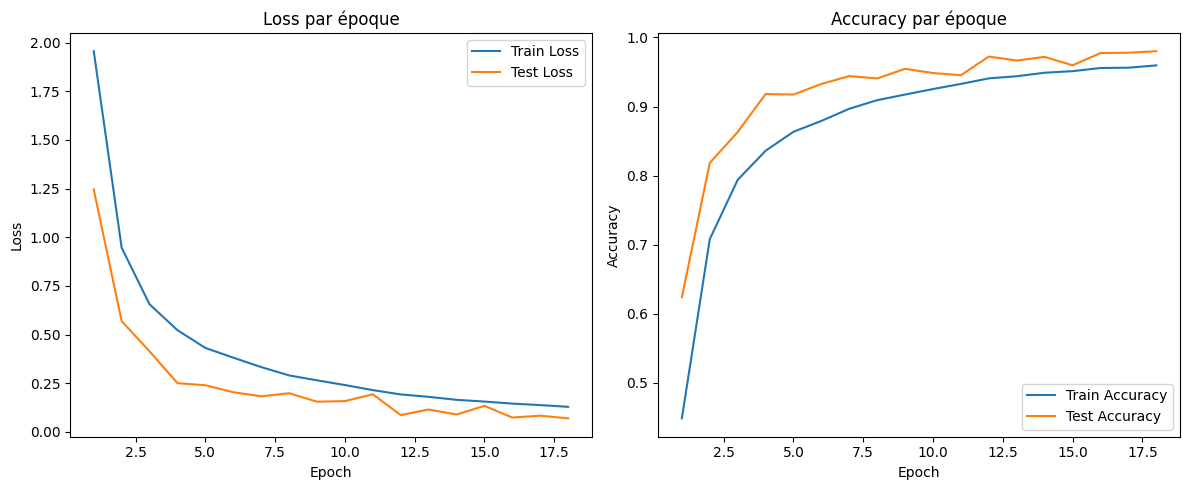

In [ ]:
plot_training_curves(stats)

## ResNet (stride = 2, no MaxPool)

In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, downsample=False):
        super().__init__()
        stride = 2 if downsample else 1

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, stride=stride)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.downsample = downsample or in_channels != out_channels
        if self.downsample:
            self.skip = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride),
                nn.BatchNorm2d(out_channels)
            )
        else:
            self.skip = nn.Identity()

    def forward(self, x):
        identity = self.skip(x)
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        return self.relu(out + identity)


In [ ]:
class ResidualCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.initial = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU()
        )

        self.layers = nn.Sequential(
            ResidualBlock(32, 64, downsample=True),   # [B, 64, 128, 128]
            ResidualBlock(64, 128, downsample=True),  # [B, 128, 64, 64]
            ResidualBlock(128, 256, downsample=True), # [B, 256, 32, 32]
            ResidualBlock(256, 512, downsample=True), # [B, 512, 16, 16]
            nn.AdaptiveAvgPool2d((1, 1))              # [B, 512, 1, 1]
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),                             # [B, 512]
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.initial(x)
        x = self.layers(x)
        x = self.classifier(x)
        return x

In [ ]:
# === Configuration ===
device = "cuda" if torch.cuda.is_available() else "cpu"
model = ResidualCNN(num_classes).to(device)

LEARNING_RATE = 0.01
NUM_EPOCHS = 20


# === Perte et optimiseur ===
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

stats = train(
    model=model,
    train_dataloader=train_dl,
    validation_dataloader=val_dl,
    loss_fn=loss_fn,
    optimizer=optimizer,
    epochs=NUM_EPOCHS,
    device=device,
    patience=10,
    track_metrics=True)


  5%|▌         | 1/20 [00:55<17:31, 55.33s/it]

Epoch: 1 | train_loss: 1.9056 | train_acc: 0.4617 | val_loss: 1.1317 | val_acc: 0.6556
✅ Validation loss improved — model saved.


 10%|█         | 2/20 [01:50<16:32, 55.16s/it]

Epoch: 2 | train_loss: 1.1344 | train_acc: 0.6542 | val_loss: 0.6999 | val_acc: 0.7831
✅ Validation loss improved — model saved.


 15%|█▌        | 3/20 [02:45<15:37, 55.12s/it]

Epoch: 3 | train_loss: 0.8577 | train_acc: 0.7321 | val_loss: 0.6136 | val_acc: 0.8088
✅ Validation loss improved — model saved.


 20%|██        | 4/20 [03:40<14:42, 55.17s/it]

Epoch: 4 | train_loss: 0.6883 | train_acc: 0.7834 | val_loss: 0.4984 | val_acc: 0.8403
✅ Validation loss improved — model saved.


 25%|██▌       | 5/20 [04:35<13:47, 55.16s/it]

Epoch: 5 | train_loss: 0.5468 | train_acc: 0.8266 | val_loss: 0.3820 | val_acc: 0.8898
✅ Validation loss improved — model saved.


 30%|███       | 6/20 [05:30<12:51, 55.13s/it]

Epoch: 6 | train_loss: 0.4559 | train_acc: 0.8557 | val_loss: 0.3684 | val_acc: 0.8890
✅ Validation loss improved — model saved.


 35%|███▌      | 7/20 [06:25<11:56, 55.12s/it]

Epoch: 7 | train_loss: 0.3858 | train_acc: 0.8763 | val_loss: 0.4597 | val_acc: 0.8530
⚠️ No improvement for 1 epoch(s).


 40%|████      | 8/20 [07:21<11:01, 55.17s/it]

Epoch: 8 | train_loss: 0.3403 | train_acc: 0.8923 | val_loss: 0.1832 | val_acc: 0.9401
✅ Validation loss improved — model saved.


 45%|████▌     | 9/20 [08:16<10:06, 55.15s/it]

Epoch: 9 | train_loss: 0.2911 | train_acc: 0.9074 | val_loss: 0.2057 | val_acc: 0.9348
⚠️ No improvement for 1 epoch(s).


 50%|█████     | 10/20 [09:11<09:11, 55.16s/it]

Epoch: 10 | train_loss: 0.2697 | train_acc: 0.9132 | val_loss: 0.1283 | val_acc: 0.9601
✅ Validation loss improved — model saved.


 55%|█████▌    | 11/20 [10:06<08:16, 55.18s/it]

Epoch: 11 | train_loss: 0.2431 | train_acc: 0.9228 | val_loss: 0.1372 | val_acc: 0.9558
⚠️ No improvement for 1 epoch(s).


 60%|██████    | 12/20 [11:01<07:21, 55.17s/it]

Epoch: 12 | train_loss: 0.2203 | train_acc: 0.9306 | val_loss: 0.1323 | val_acc: 0.9568
⚠️ No improvement for 2 epoch(s).


 65%|██████▌   | 13/20 [11:57<06:26, 55.20s/it]

Epoch: 13 | train_loss: 0.1952 | train_acc: 0.9386 | val_loss: 0.1316 | val_acc: 0.9590
⚠️ No improvement for 3 epoch(s).


 70%|███████   | 14/20 [12:52<05:31, 55.18s/it]

Epoch: 14 | train_loss: 0.1791 | train_acc: 0.9424 | val_loss: 0.1064 | val_acc: 0.9648
✅ Validation loss improved — model saved.


 75%|███████▌  | 15/20 [13:47<04:36, 55.24s/it]

Epoch: 15 | train_loss: 0.1761 | train_acc: 0.9448 | val_loss: 0.1011 | val_acc: 0.9692
✅ Validation loss improved — model saved.


 80%|████████  | 16/20 [14:42<03:40, 55.21s/it]

Epoch: 16 | train_loss: 0.1632 | train_acc: 0.9479 | val_loss: 0.1440 | val_acc: 0.9594
⚠️ No improvement for 1 epoch(s).


 85%|████████▌ | 17/20 [15:37<02:45, 55.18s/it]

Epoch: 17 | train_loss: 0.1552 | train_acc: 0.9515 | val_loss: 0.0854 | val_acc: 0.9739
✅ Validation loss improved — model saved.


 90%|█████████ | 18/20 [16:33<01:50, 55.25s/it]

Epoch: 18 | train_loss: 0.1433 | train_acc: 0.9540 | val_loss: 0.1361 | val_acc: 0.9568
⚠️ No improvement for 1 epoch(s).


 95%|█████████▌| 19/20 [17:28<00:55, 55.26s/it]

Epoch: 19 | train_loss: 0.1350 | train_acc: 0.9590 | val_loss: 0.1576 | val_acc: 0.9558
⚠️ No improvement for 2 epoch(s).


100%|██████████| 20/20 [18:23<00:00, 55.19s/it]

Epoch: 20 | train_loss: 0.1351 | train_acc: 0.9574 | val_loss: 0.0699 | val_acc: 0.9812
✅ Validation loss improved — model saved.

🏁 Best model restored from epoch 20 with val_loss = 0.0699


In [ ]:
drive.mount('/content/drive', force_remount="True")

#on créer le répertoire
MODEL_PATH = Path("/content/drive/MyDrive/models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

#maintenant le chemin de sauvegarde
MODEL_NAME = "01_ResidualCNN_wStride2.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

#sauvegarder le state_dict du modèle
print(f"Saving model to : {MODEL_SAVE_PATH}")
torch.save(obj=model.state_dict(), f=MODEL_SAVE_PATH)

Mounted at /content/drive
Saving model to : /content/drive/MyDrive/models/01_ResidualCNN_wStride2.pth


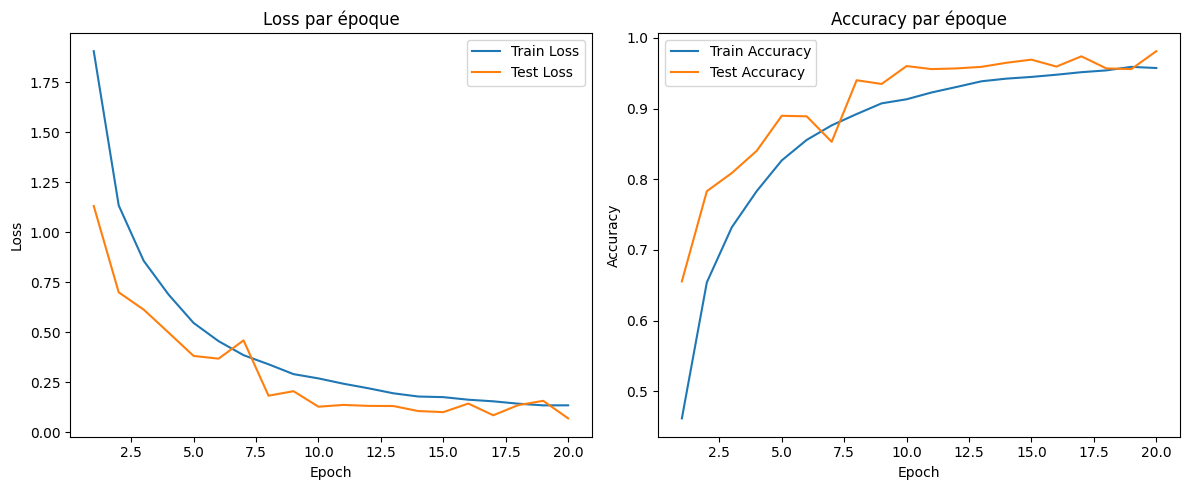

In [ ]:
plot_training_curves(stats)

##ResNet avec LR + régul L2 (weight decay) + grad_clip

In [ ]:
import torch

from tqdm.auto import tqdm
from typing import Dict, List, Tuple

def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device,
               scheduler=None,
               grad_clip=None,
               lr_history=None) -> Tuple[float, float]:

    model.train()
    train_loss = 0.0
    correct_preds = 0
    total_samples = 0

    for X, y in dataloader:
        X, y = X.to(device), y.to(device)

        # Forward pass
        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()

        # gradient clipping
        if grad_clip:
            nn.utils.clip_grad_value_(model.parameters(), grad_clip)


        optimizer.step()

        #Scheduler step
        if scheduler:
            scheduler.step()
            if lr_history is not None:
                lr_history.append(optimizer.param_groups[0]["lr"])

        # Accuracy calculation
        y_pred_class = torch.argmax(y_pred, dim=1)
        correct_preds += (y_pred_class == y).sum().item()
        total_samples += y.size(0)

    avg_loss = train_loss / len(dataloader)
    avg_acc = correct_preds / total_samples
    return avg_loss, avg_acc


def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device: torch.device) -> Tuple[float, float]:

    model.eval()
    test_loss = 0.0
    correct_preds = 0
    total_samples = 0

    with torch.inference_mode():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)

            y_pred = model(X)
            loss = loss_fn(y_pred, y)
            test_loss += loss.item()

            y_pred_class = torch.argmax(y_pred, dim=1)
            correct_preds += (y_pred_class == y).sum().item()
            total_samples += y.size(0)

    avg_loss = test_loss / len(dataloader)
    avg_acc = correct_preds / total_samples
    return avg_loss, avg_acc




In [ ]:
import torch
import time
import copy
from tqdm import tqdm
from typing import Dict, List, Union

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          validation_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          max_lr: float,
          weight_decay: float,
          grad_clip: float,
          device: torch.device,
          patience: int = 2,
          track_metrics: bool = True
          ) -> Union[Dict[str, List[float]], Dict[str, float]]:
    """
    Entraîne un modèle PyTorch avec OneCycleLR, early stopping, tracking LR, et stats flexibles.

    Args:
        model: Le modèle à entraîner.
        train_dataloader: DataLoader pour l'entraînement.
        validation_dataloader: DataLoader pour la validation.
        optimizer: Optimiseur.
        loss_fn: Fonction de perte.
        epochs: Nombre d'époques max.
        max_lr: Learning rate max pour OneCycleLR.
        weight_decay: Régularisation L2.
        grad_clip: Valeur de gradient clipping.
        device: Appareil de calcul.
        patience: Early stopping (nombre d'époques sans amélioration).
        track_metrics: Si False, retourne uniquement les métriques finales.

    Returns:
        Dictionnaire des courbes ou des valeurs finales.
    """

    scheduler = torch.optim.lr_scheduler.OneCycleLR(
        optimizer, max_lr=max_lr,
        steps_per_epoch=len(train_dataloader),
        epochs=epochs
    )

    lr_history = []
    if track_metrics:
        results = {
            "train_loss": [],
            "train_acc": [],
            "test_loss": [],
            "test_acc": [],
            "lr": []
        }
    else:
        results = {}

    best_model_wts = copy.deepcopy(model.state_dict())
    best_val_loss = float('inf')
    best_epoch = 0
    epochs_without_improvement = 0

    start_time = time.time()

    for epoch in tqdm(range(epochs), desc="Training epochs"):
        train_loss, train_acc = train_step(
            model=model,
            dataloader=train_dataloader,
            loss_fn=loss_fn,
            optimizer=optimizer,
            device=device,
            scheduler=scheduler,
            grad_clip=grad_clip,
            lr_history=lr_history
        )

        val_loss, val_acc = test_step(
            model=model,
            dataloader=validation_dataloader,
            loss_fn=loss_fn,
            device=device
        )

        if track_metrics:
            print(f"Epoch {epoch+1} | "
                  f"train_loss: {train_loss:.4f} | train_acc: {train_acc:.4f} | "
                  f"val_loss: {val_loss:.4f} | val_acc: {val_acc:.4f}")

            results["train_loss"].append(train_loss)
            results["train_acc"].append(train_acc)
            results["test_loss"].append(val_loss)
            results["test_acc"].append(val_acc)

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            best_epoch = epoch
            epochs_without_improvement = 0
            print("✅ Validation loss improved — model saved.")
        else:
            epochs_without_improvement += 1
            print(f"⚠️ No improvement for {epochs_without_improvement} epoch(s).")

            if epochs_without_improvement >= patience:
                print("⏹️ Early stopping triggered.")
                break

    total_time = time.time() - start_time
    model.load_state_dict(best_model_wts)

    print(f"\n🏁 Best model restored from epoch {best_epoch+1} with val_loss = {best_val_loss:.4f}")

    if track_metrics:
        # Tronquer les courbes jusqu'à la meilleure époque
        for key in results:
            if isinstance(results[key], list):  # on ignore "lr" si vide
                results[key] = results[key][:best_epoch + 1]
        results["lr"] = lr_history[:sum(len(train_dataloader) for _ in range(best_epoch + 1))]
        results["total_time"] = [total_time]
        return results
    else:
        return {
            "final_train_loss": train_loss,
            "final_train_acc": train_acc,
            "final_val_loss": val_loss,
            "final_val_acc": val_acc,
            "total_time": total_time
        }


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResidualCNN(num_classes=num_classes).to(device)

# Hyperparamètres
MAX_LR = 0.01
NUM_EPOCHS = 20
WEIGHT_DECAY = 1e-4
GRAD_CLIP = 1.0
PATIENCE = 10

loss_fn = torch.nn.CrossEntropyLoss()
optimizer_fn = torch.optim.Adam(model.parameters(),lr=MAX_LR, weight_decay=WEIGHT_DECAY)

stats = train(
    model=model,
    train_dataloader=train_dl,
    validation_dataloader=val_dl,
    optimizer=optimizer_fn,
    loss_fn=loss_fn,
    epochs=NUM_EPOCHS,
    max_lr=MAX_LR,
    weight_decay=WEIGHT_DECAY,
    grad_clip=GRAD_CLIP,
    device=device,
    patience=PATIENCE
)


Training epochs:   5%|▌         | 1/20 [00:55<17:30, 55.31s/it]

Epoch 1 | train_loss: 1.2284 | train_acc: 0.6348 | val_loss: 1.0567 | val_acc: 0.6890
✅ Validation loss improved — model saved.


Training epochs:  10%|█         | 2/20 [01:50<16:37, 55.44s/it]

Epoch 2 | train_loss: 0.7921 | train_acc: 0.7535 | val_loss: 0.8611 | val_acc: 0.7468
✅ Validation loss improved — model saved.


Training epochs:  15%|█▌        | 3/20 [02:46<15:41, 55.40s/it]

Epoch 3 | train_loss: 0.6587 | train_acc: 0.7932 | val_loss: 0.7081 | val_acc: 0.7748
✅ Validation loss improved — model saved.


Training epochs:  20%|██        | 4/20 [03:41<14:45, 55.36s/it]

Epoch 4 | train_loss: 0.5755 | train_acc: 0.8186 | val_loss: 0.5269 | val_acc: 0.8372
✅ Validation loss improved — model saved.


Training epochs:  25%|██▌       | 5/20 [04:37<13:51, 55.42s/it]

Epoch 5 | train_loss: 0.5531 | train_acc: 0.8262 | val_loss: 0.5793 | val_acc: 0.8090
⚠️ No improvement for 1 epoch(s).


Training epochs:  30%|███       | 6/20 [05:32<12:55, 55.42s/it]

Epoch 6 | train_loss: 0.5020 | train_acc: 0.8443 | val_loss: 0.3936 | val_acc: 0.8762
✅ Validation loss improved — model saved.


Training epochs:  35%|███▌      | 7/20 [06:27<11:59, 55.37s/it]

Epoch 7 | train_loss: 0.4267 | train_acc: 0.8632 | val_loss: 0.8935 | val_acc: 0.7652
⚠️ No improvement for 1 epoch(s).


Training epochs:  40%|████      | 8/20 [07:23<11:04, 55.35s/it]

Epoch 8 | train_loss: 0.3865 | train_acc: 0.8767 | val_loss: 0.2842 | val_acc: 0.9074
✅ Validation loss improved — model saved.


Training epochs:  45%|████▌     | 9/20 [08:18<10:09, 55.37s/it]

Epoch 9 | train_loss: 0.3339 | train_acc: 0.8925 | val_loss: 0.3254 | val_acc: 0.9029
⚠️ No improvement for 1 epoch(s).


Training epochs:  50%|█████     | 10/20 [09:13<09:14, 55.42s/it]

Epoch 10 | train_loss: 0.2977 | train_acc: 0.9059 | val_loss: 0.2200 | val_acc: 0.9280
✅ Validation loss improved — model saved.


Training epochs:  55%|█████▌    | 11/20 [10:09<08:18, 55.37s/it]

Epoch 11 | train_loss: 0.2749 | train_acc: 0.9118 | val_loss: 0.2381 | val_acc: 0.9202
⚠️ No improvement for 1 epoch(s).


Training epochs:  60%|██████    | 12/20 [11:04<07:22, 55.37s/it]

Epoch 12 | train_loss: 0.2374 | train_acc: 0.9247 | val_loss: 0.2239 | val_acc: 0.9371
⚠️ No improvement for 2 epoch(s).


Training epochs:  65%|██████▌   | 13/20 [11:59<06:27, 55.35s/it]

Epoch 13 | train_loss: 0.2073 | train_acc: 0.9338 | val_loss: 0.1568 | val_acc: 0.9478
✅ Validation loss improved — model saved.


Training epochs:  70%|███████   | 14/20 [12:55<05:31, 55.32s/it]

Epoch 14 | train_loss: 0.1776 | train_acc: 0.9423 | val_loss: 0.1099 | val_acc: 0.9630
✅ Validation loss improved — model saved.


Training epochs:  75%|███████▌  | 15/20 [13:50<04:36, 55.31s/it]

Epoch 15 | train_loss: 0.1444 | train_acc: 0.9529 | val_loss: 0.1039 | val_acc: 0.9657
✅ Validation loss improved — model saved.


Training epochs:  80%|████████  | 16/20 [14:45<03:41, 55.31s/it]

Epoch 16 | train_loss: 0.1188 | train_acc: 0.9613 | val_loss: 0.0706 | val_acc: 0.9776
✅ Validation loss improved — model saved.


Training epochs:  85%|████████▌ | 17/20 [15:41<02:46, 55.34s/it]

Epoch 17 | train_loss: 0.0960 | train_acc: 0.9687 | val_loss: 0.0519 | val_acc: 0.9828
✅ Validation loss improved — model saved.


Training epochs:  90%|█████████ | 18/20 [16:36<01:50, 55.32s/it]

Epoch 18 | train_loss: 0.0769 | train_acc: 0.9751 | val_loss: 0.0454 | val_acc: 0.9857
✅ Validation loss improved — model saved.


Training epochs:  95%|█████████▌| 19/20 [17:31<00:55, 55.34s/it]

Epoch 19 | train_loss: 0.0670 | train_acc: 0.9791 | val_loss: 0.0392 | val_acc: 0.9886
✅ Validation loss improved — model saved.


Training epochs: 100%|██████████| 20/20 [18:27<00:00, 55.35s/it]

Epoch 20 | train_loss: 0.0604 | train_acc: 0.9807 | val_loss: 0.0402 | val_acc: 0.9876
⚠️ No improvement for 1 epoch(s).

🏁 Best model restored from epoch 19 with val_loss = 0.0392


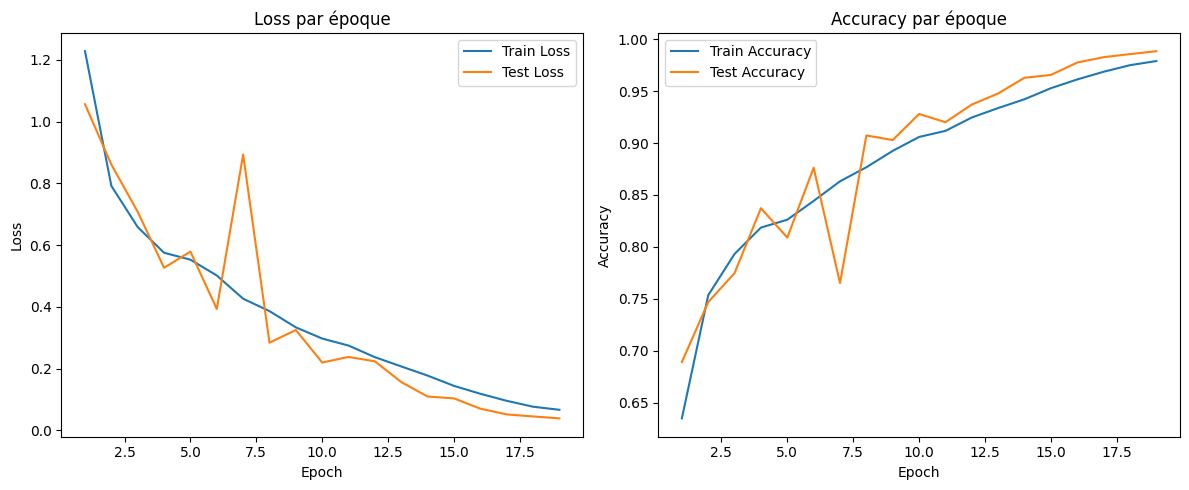

In [ ]:
plot_training_curves(stats)

In [ ]:
import torch.nn as nn

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, stride=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, stride=1)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.need_skip_conv = in_channels != out_channels
        if self.need_skip_conv:
            self.skip = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1),
                nn.BatchNorm2d(out_channels)
            )
        else:
            self.skip = nn.Identity()

    def forward(self, x):
        identity = self.skip(x)
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        return self.relu(out + identity)

class ResidualCNN_MP(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.initial = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU()
        )

        self.layer1 = nn.Sequential(
            ResidualBlock(32, 64),
            nn.MaxPool2d(2)  # [B, 64, H/2, W/2]
        )
        self.layer2 = nn.Sequential(
            ResidualBlock(64, 128),
            nn.MaxPool2d(2)  # [B, 128, H/4, W/4]
        )
        self.layer3 = nn.Sequential(
            ResidualBlock(128, 256),
            nn.MaxPool2d(2)  # [B, 256, H/8, W/8]
        )
        self.layer4 = nn.Sequential(
            ResidualBlock(256, 512),
            nn.MaxPool2d(2)  # [B, 512, H/16, W/16]
        )
        self.pool = nn.AdaptiveAvgPool2d((1, 1))      # [B, 512, 1, 1]

        self.classifier = nn.Sequential(
            nn.Flatten(),                             # [B, 512]
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.initial(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.pool(x)
        x = self.classifier(x)
        return x


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResidualCNN_MP(num_classes=num_classes).to(device)

# Hyperparamètres
MAX_LR = 0.01
NUM_EPOCHS = 20
WEIGHT_DECAY = 1e-4
GRAD_CLIP = 1.0
PATIENCE = 3

loss_fn = torch.nn.CrossEntropyLoss()
optimizer_fn = torch.optim.Adam(model.parameters(),lr=MAX_LR, weight_decay=WEIGHT_DECAY)

stats = train(
    model=model,
    train_dataloader=train_dl,
    validation_dataloader=val_dl,
    optimizer=optimizer_fn,
    loss_fn=loss_fn,
    epochs=NUM_EPOCHS,
    max_lr=MAX_LR,
    weight_decay=WEIGHT_DECAY,
    grad_clip=GRAD_CLIP,
    device=device,
    patience=PATIENCE
)


Training epochs:   5%|▌         | 1/20 [02:23<45:25, 143.43s/it]

Epoch 1 | train_loss: 1.0763 | train_acc: 0.6805 | val_loss: 0.8445 | val_acc: 0.7458
✅ Validation loss improved — model saved.


Training epochs:  10%|█         | 2/20 [04:46<43:01, 143.44s/it]

Epoch 2 | train_loss: 0.6382 | train_acc: 0.7994 | val_loss: 0.6139 | val_acc: 0.8104
✅ Validation loss improved — model saved.


Training epochs:  15%|█▌        | 3/20 [07:10<40:37, 143.36s/it]

Epoch 3 | train_loss: 0.5197 | train_acc: 0.8348 | val_loss: 0.3673 | val_acc: 0.8786
✅ Validation loss improved — model saved.


Training epochs:  20%|██        | 4/20 [09:33<38:13, 143.35s/it]

Epoch 4 | train_loss: 0.4651 | train_acc: 0.8533 | val_loss: 0.4812 | val_acc: 0.8567
⚠️ No improvement for 1 epoch(s).


Training epochs:  25%|██▌       | 5/20 [11:56<35:49, 143.30s/it]

Epoch 5 | train_loss: 0.4415 | train_acc: 0.8627 | val_loss: 0.3964 | val_acc: 0.8785
⚠️ No improvement for 2 epoch(s).


Training epochs:  25%|██▌       | 5/20 [14:19<42:59, 171.98s/it]

Epoch 6 | train_loss: 0.3943 | train_acc: 0.8757 | val_loss: 0.3805 | val_acc: 0.8844
⚠️ No improvement for 3 epoch(s).
⏹️ Early stopping triggered.

🏁 Best model restored from epoch 3 with val_loss = 0.3673


### visualiser le LR au cours du temps


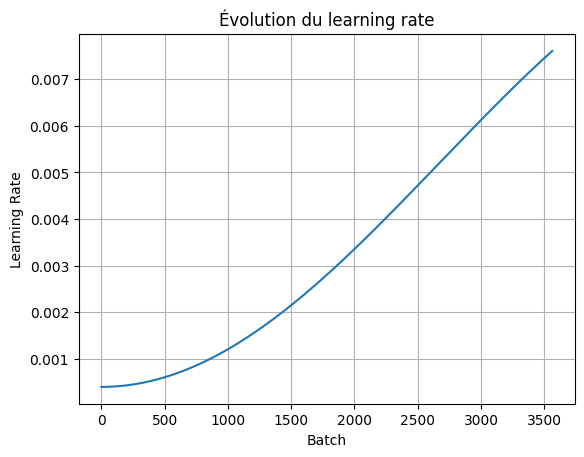

In [ ]:
import matplotlib.pyplot as plt

plt.plot(stats["lr"])
plt.title("Évolution du learning rate")
plt.xlabel("Batch")
plt.ylabel("Learning Rate")
plt.grid(True)
plt.show()


In [ ]:
drive.mount('/content/drive', force_remount="True")

#on créer le répertoire
MODEL_PATH = Path("/content/drive/MyDrive/models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

#maintenant le chemin de sauvegarde
MODEL_NAME = "02_ResidualCNN_wLR_L2_GRADCLIP.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

#sauvegarder le state_dict du modèle
print(f"Saving model to : {MODEL_SAVE_PATH}")
torch.save(obj=model.state_dict(), f=MODEL_SAVE_PATH)

Mounted at /content/drive
Saving model to : /content/drive/MyDrive/models/02_ResidualCNN_wLR_L2_GRADCLIP.pth


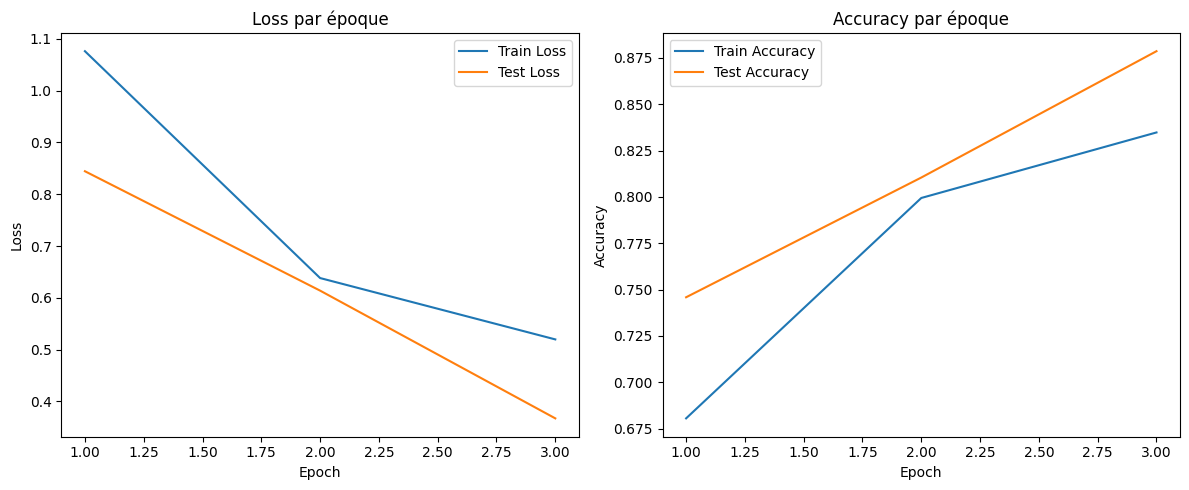

In [ ]:
plot_training_curves(stats)

## ResNet_minimal (-- params)

In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, downsample=False):
        super().__init__()
        stride = 2 if downsample else 1

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, stride=stride)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.downsample = downsample or in_channels != out_channels
        if self.downsample:
            self.skip = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride),
                nn.BatchNorm2d(out_channels)
            )
        else:
            self.skip = nn.Identity()

    def forward(self, x):
        identity = self.skip(x)
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        return self.relu(out + identity)


In [ ]:
class ResidualCNN_minimal(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.initial = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU()
        )

        self.layers = nn.Sequential(
            ResidualBlock(32, 64, downsample=True),   # [B, 64, 128, 128]
            ResidualBlock(64, 128, downsample=True),  # [B, 128, 64, 64]
            ResidualBlock(128, 256, downsample=True), # [B, 256, 32, 32]
            nn.AdaptiveAvgPool2d((1, 1))              # [B, 512, 1, 1]
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),                             # [B, 256]
            nn.Dropout(0.2),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.initial(x)
        x = self.layers(x)
        x = self.classifier(x)
        return x


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResidualCNN_minimal(num_classes=num_classes).to(device)

# Hyperparamètres
MAX_LR = 0.01
NUM_EPOCHS = 20
WEIGHT_DECAY = 1e-4
GRAD_CLIP = 1.0
PATIENCE = 10

loss_fn = torch.nn.CrossEntropyLoss()
optimizer_fn = torch.optim.Adam(model.parameters(),lr=MAX_LR, weight_decay=WEIGHT_DECAY)

stats = train(
    model=model,
    train_dataloader=train_dl,
    validation_dataloader=val_dl,
    optimizer=optimizer_fn,
    loss_fn=loss_fn,
    epochs=NUM_EPOCHS,
    max_lr=MAX_LR,
    weight_decay=WEIGHT_DECAY,
    grad_clip=GRAD_CLIP,
    device=device,
    patience=PATIENCE
)


Training epochs:   5%|▌         | 1/20 [00:51<16:12, 51.20s/it]

Epoch 1 | train_loss: 1.2620 | train_acc: 0.6463 | val_loss: 1.0748 | val_acc: 0.6731
✅ Validation loss improved — model saved.


Training epochs:  10%|█         | 2/20 [01:42<15:22, 51.26s/it]

Epoch 2 | train_loss: 0.7498 | train_acc: 0.7686 | val_loss: 0.6214 | val_acc: 0.8144
✅ Validation loss improved — model saved.


Training epochs:  15%|█▌        | 3/20 [02:33<14:31, 51.24s/it]

Epoch 3 | train_loss: 0.6385 | train_acc: 0.8023 | val_loss: 0.8114 | val_acc: 0.7436
⚠️ No improvement for 1 epoch(s).


Training epochs:  20%|██        | 4/20 [03:24<13:40, 51.26s/it]

Epoch 4 | train_loss: 0.5530 | train_acc: 0.8280 | val_loss: 0.4024 | val_acc: 0.8716
✅ Validation loss improved — model saved.


Training epochs:  25%|██▌       | 5/20 [04:16<12:48, 51.24s/it]

Epoch 5 | train_loss: 0.4975 | train_acc: 0.8424 | val_loss: 0.8462 | val_acc: 0.7420
⚠️ No improvement for 1 epoch(s).


Training epochs:  30%|███       | 6/20 [05:07<11:57, 51.22s/it]

Epoch 6 | train_loss: 0.4477 | train_acc: 0.8586 | val_loss: 0.3221 | val_acc: 0.8945
✅ Validation loss improved — model saved.


Training epochs:  35%|███▌      | 7/20 [05:58<11:06, 51.28s/it]

Epoch 7 | train_loss: 0.4222 | train_acc: 0.8697 | val_loss: 0.5778 | val_acc: 0.8245
⚠️ No improvement for 1 epoch(s).


Training epochs:  40%|████      | 8/20 [06:50<10:15, 51.26s/it]

Epoch 8 | train_loss: 0.3702 | train_acc: 0.8842 | val_loss: 0.3701 | val_acc: 0.8842
⚠️ No improvement for 2 epoch(s).


Training epochs:  45%|████▌     | 9/20 [07:41<09:23, 51.27s/it]

Epoch 9 | train_loss: 0.3465 | train_acc: 0.8904 | val_loss: 0.2759 | val_acc: 0.9130
✅ Validation loss improved — model saved.


Training epochs:  50%|█████     | 10/20 [08:32<08:32, 51.29s/it]

Epoch 10 | train_loss: 0.3252 | train_acc: 0.8979 | val_loss: 0.4095 | val_acc: 0.8788
⚠️ No improvement for 1 epoch(s).


Training epochs:  55%|█████▌    | 11/20 [09:24<07:41, 51.32s/it]

Epoch 11 | train_loss: 0.2920 | train_acc: 0.9092 | val_loss: 0.1936 | val_acc: 0.9380
✅ Validation loss improved — model saved.


Training epochs:  60%|██████    | 12/20 [10:15<06:50, 51.35s/it]

Epoch 12 | train_loss: 0.2730 | train_acc: 0.9144 | val_loss: 0.1874 | val_acc: 0.9432
✅ Validation loss improved — model saved.


Training epochs:  65%|██████▌   | 13/20 [11:06<05:59, 51.30s/it]

Epoch 13 | train_loss: 0.2369 | train_acc: 0.9255 | val_loss: 0.1514 | val_acc: 0.9520
✅ Validation loss improved — model saved.


Training epochs:  70%|███████   | 14/20 [11:57<05:07, 51.29s/it]

Epoch 14 | train_loss: 0.2091 | train_acc: 0.9356 | val_loss: 0.1361 | val_acc: 0.9567
✅ Validation loss improved — model saved.


Training epochs:  75%|███████▌  | 15/20 [12:49<04:16, 51.30s/it]

Epoch 15 | train_loss: 0.1826 | train_acc: 0.9417 | val_loss: 0.1281 | val_acc: 0.9589
✅ Validation loss improved — model saved.


Training epochs:  80%|████████  | 16/20 [13:40<03:25, 51.33s/it]

Epoch 16 | train_loss: 0.1585 | train_acc: 0.9504 | val_loss: 0.0819 | val_acc: 0.9763
✅ Validation loss improved — model saved.


Training epochs:  85%|████████▌ | 17/20 [14:32<02:34, 51.35s/it]

Epoch 17 | train_loss: 0.1297 | train_acc: 0.9598 | val_loss: 0.0688 | val_acc: 0.9788
✅ Validation loss improved — model saved.


Training epochs:  90%|█████████ | 18/20 [15:23<01:42, 51.30s/it]

Epoch 18 | train_loss: 0.1118 | train_acc: 0.9658 | val_loss: 0.0606 | val_acc: 0.9824
✅ Validation loss improved — model saved.


Training epochs:  95%|█████████▌| 19/20 [16:14<00:51, 51.31s/it]

Epoch 19 | train_loss: 0.0985 | train_acc: 0.9704 | val_loss: 0.0553 | val_acc: 0.9849
✅ Validation loss improved — model saved.


Training epochs: 100%|██████████| 20/20 [17:05<00:00, 51.30s/it]

Epoch 20 | train_loss: 0.0876 | train_acc: 0.9738 | val_loss: 0.0558 | val_acc: 0.9836
⚠️ No improvement for 1 epoch(s).

🏁 Best model restored from epoch 19 with val_loss = 0.0553


In [ ]:
drive.mount('/content/drive', force_remount="True")

#on créer le répertoire
MODEL_PATH = Path("/content/drive/MyDrive/models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

#maintenant le chemin de sauvegarde
MODEL_NAME = "01_ResidualCNN_minimal.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

#sauvegarder le state_dict du modèle
print(f"Saving model to : {MODEL_SAVE_PATH}")
torch.save(obj=model.state_dict(), f=MODEL_SAVE_PATH)

Mounted at /content/drive
Saving model to : /content/drive/MyDrive/models/01_ResidualCNN_minimal.pth


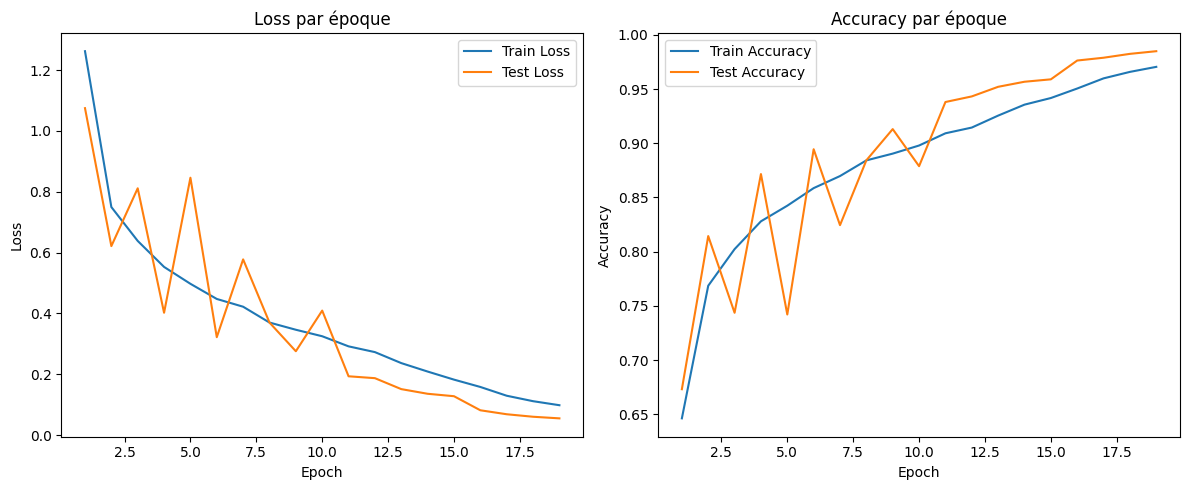

In [ ]:
plot_training_curves(stats)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResidualCNN_minimal(num_classes=num_classes).to(device)

# Hyperparamètres
MAX_LR = 0.01
NUM_EPOCHS = 30
WEIGHT_DECAY = 1e-4
GRAD_CLIP = 2.0
PATIENCE = 10

loss_fn = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer_fn = torch.optim.Adam(model.parameters(),lr=MAX_LR, weight_decay=WEIGHT_DECAY)

stats = train(
    model=model,
    train_dataloader=train_dl,
    validation_dataloader=val_dl,
    optimizer=optimizer_fn,
    loss_fn=loss_fn,
    epochs=NUM_EPOCHS,
    max_lr=MAX_LR,
    weight_decay=WEIGHT_DECAY,
    grad_clip=GRAD_CLIP,
    device=device,
    patience=PATIENCE
)


Training epochs:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 1 | train_loss: 1.7580 | train_acc: 0.6506 | val_loss: 1.4495 | val_acc: 0.7594
✅ Validation loss improved — model saved.
Epoch 2 | train_loss: 1.3777 | train_acc: 0.7862 | val_loss: 1.5304 | val_acc: 0.7514
⚠️ No improvement for 1 epoch(s).
Epoch 3 | train_loss: 1.2671 | train_acc: 0.8301 | val_loss: 1.2177 | val_acc: 0.8547
✅ Validation loss improved — model saved.
Epoch 4 | train_loss: 1.1877 | train_acc: 0.8655 | val_loss: 1.1637 | val_acc: 0.9015
✅ Validation loss improved — model saved.
Epoch 5 | train_loss: 1.1658 | train_acc: 0.8758 | val_loss: 1.4139 | val_acc: 0.7814
⚠️ No improvement for 1 epoch(s).
Epoch 6 | train_loss: 1.1458 | train_acc: 0.8841 | val_loss: 1.2552 | val_acc: 0.8566
⚠️ No improvement for 2 epoch(s).
Epoch 7 | train_loss: 1.1370 | train_acc: 0.8875 | val_loss: 1.2226 | val_acc: 0.8625
⚠️ No improvement for 3 epoch(s).
Epoch 8 | train_loss: 1.1235 | train_acc: 0.8905 | val_loss: 1.4821 | val_acc: 0.7858
⚠️ No improvement for 4 epoch(s).
Epoch 9 | train_

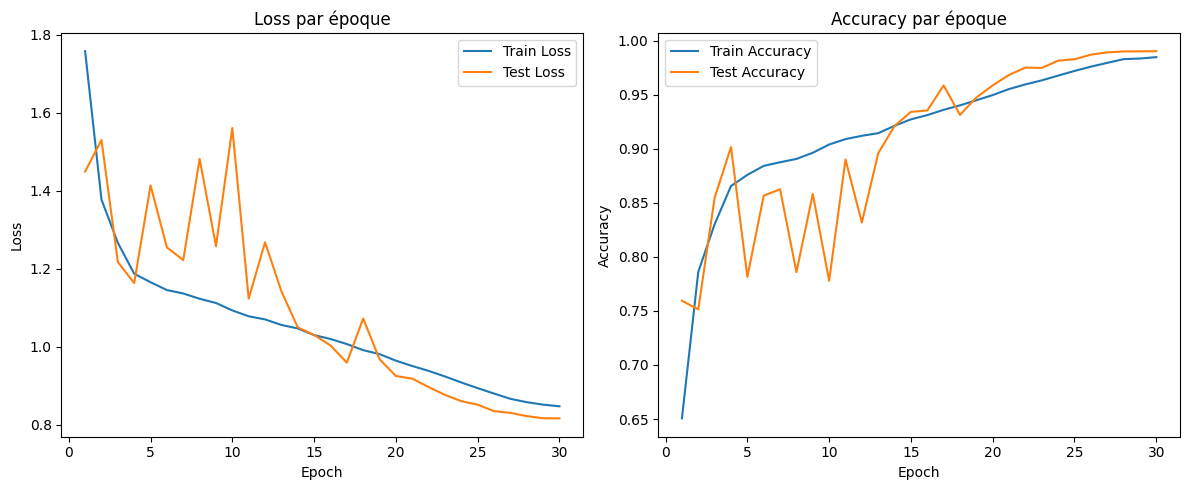

In [ ]:
plot_training_curves(stats)

In [ ]:
class ResidualCNN_minimal2(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.initial = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU()
        )

        self.layers = nn.Sequential(
            ResidualBlock(32, 64, downsample=True),   # [B, 64, 128, 128]
            ResidualBlock(64, 128, downsample=True),  # [B, 128, 64, 64]
            ResidualBlock(128, 256, downsample=True), # [B, 256, 32, 32]
            ResidualBlock(256, 512, downsample=True),
            nn.AdaptiveAvgPool2d((1, 1))              # [B, 512, 1, 1]
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.2),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.initial(x)
        x = self.layers(x)
        x = self.classifier(x)
        return x


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResidualCNN_minimal2(num_classes=num_classes).to(device)

# Hyperparamètres
MAX_LR = 0.01
NUM_EPOCHS = 30
WEIGHT_DECAY = 1e-4
GRAD_CLIP = 2.0
PATIENCE = 10

loss_fn = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer_fn = torch.optim.Adam(model.parameters(),lr=MAX_LR, weight_decay=WEIGHT_DECAY)

stats = train(
    model=model,
    train_dataloader=train_dl,
    validation_dataloader=val_dl,
    optimizer=optimizer_fn,
    loss_fn=loss_fn,
    epochs=NUM_EPOCHS,
    max_lr=MAX_LR,
    weight_decay=WEIGHT_DECAY,
    grad_clip=GRAD_CLIP,
    device=device,
    patience=PATIENCE
)


Training epochs:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 1 | train_loss: 1.6977 | train_acc: 0.6682 | val_loss: 1.5300 | val_acc: 0.7215
✅ Validation loss improved — model saved.
Epoch 2 | train_loss: 1.3376 | train_acc: 0.8011 | val_loss: 1.4168 | val_acc: 0.7746
✅ Validation loss improved — model saved.
Epoch 3 | train_loss: 1.2551 | train_acc: 0.8320 | val_loss: 1.4495 | val_acc: 0.7509
⚠️ No improvement for 1 epoch(s).
Epoch 4 | train_loss: 1.2106 | train_acc: 0.8496 | val_loss: 1.2159 | val_acc: 0.8503
✅ Validation loss improved — model saved.
Epoch 5 | train_loss: 1.1578 | train_acc: 0.8716 | val_loss: 1.2256 | val_acc: 0.8450
⚠️ No improvement for 1 epoch(s).
Epoch 6 | train_loss: 1.1366 | train_acc: 0.8797 | val_loss: 1.4343 | val_acc: 0.7798
⚠️ No improvement for 2 epoch(s).
Epoch 7 | train_loss: 1.1357 | train_acc: 0.8811 | val_loss: 1.2220 | val_acc: 0.8606
⚠️ No improvement for 3 epoch(s).
Epoch 8 | train_loss: 1.1172 | train_acc: 0.8860 | val_loss: 1.0753 | val_acc: 0.9130
✅ Validation loss improved — model saved.
Epoch 9 

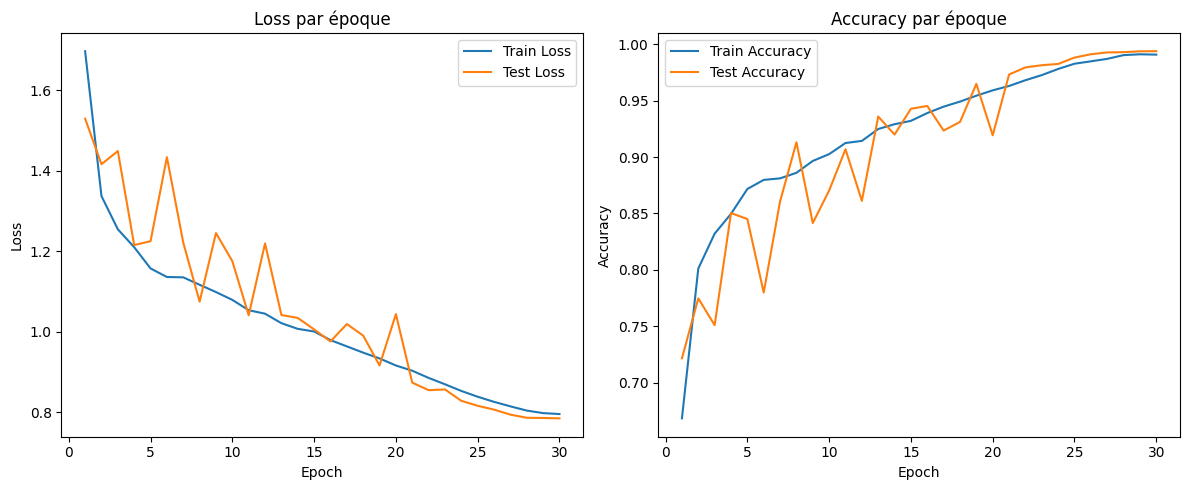

In [ ]:
plot_training_curves(stats)